<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/main/evidence_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evidence Network example

In [ ]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 115.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 68.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
!pip install optuna
!pip install optuna.integration


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00


In [ ]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul  8 16:08:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.integration import TFKerasPruningCallback

import requests
import time


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Import Data and Save as Numpy file
Once Numpy file is created it is not necessary to run this

In [ ]:
# import and save data as npy file
train_Illu = np.loadtxt(path+"/galaxies_IllustrisTNG_z=0.00.txt", float)
train_SIMB = np.loadtxt(path+"/galaxies_SIMBA_z=0.00.txt", float)

f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()

np.save(path+'/gal_Illu.npy',train_Illu)
np.save(path+'/gal_SIMB.npy',train_SIMB)


In [ ]:
f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()
header = header.split('|')
print(header[0:10])
# gal_Illu

['# ', ' gas mass ', ' stellar mass ', ' black-hole mass ', ' total mass ', ' Vmax ', ' velocity dispersion ', ' gas metallicity ', ' stars metallicity ', ' star-formation rate ']


## Load and prepare data
Each data file contains >100,000 data vectors. Note that SIMBA is about a 1.6x larger dataset than IllustrisTNG. A data vector is a package of 17 properties for a given galaxy. The values are normalised as they range over several orders of magnitude. A dataframe for each model is made to examine the data, but the numpy array is fed into the network as this is faster. <br>
The models are assigned the labels; SIMBA (1), IllustrisTNG (0). They are combined into one set of training data. x_train is the data and y_train is the labels.


In [ ]:
# unpack data
train_Illu = np.load(path+'/gal_Illu.npy')
train_SIMB = np.load(path+'/gal_SIMB.npy')
print(np.shape(train_Illu))

# get headers and convert to pandas
header = 'gas mass | stellar mass | black-hole mass | total mass | Vmax | velocity dispersion | gas metallicity | stars metallicity | star-formation rate | spin | peculiar velocity | stellar radius | total radius | Vmax radius | U | K | g'
header = header.split('|')

df_Illu = pd.DataFrame(train_Illu, columns=header)
df_SIMB = pd.DataFrame(train_SIMB, columns=header)

# add model labels 'm'
df_Illu['m'] = np.zeros(df_Illu.shape[0])
df_SIMB['m'] = np.ones(df_SIMB.shape[0])



(720548, 17)


In [ ]:
df_gal = df_Illu.append(df_SIMB)
df_gal.head()
# df_gal.iloc[0:5,0:5]

<ipython-input-18-bbc7c8626d90>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gal = df_Illu.append(df_SIMB)


,gas mass,stellar mass,black-hole mass,total mass,Vmax,velocity dispersion,gas metallicity,stars metallicity,star-formation rate,spin,peculiar velocity,stellar radius,total radius,Vmax radius,U,K,g,m
0,9.282650e+12,5.420345e+11,1.466206e+09,6.418189e+13,728.5484,388.82180,0.004787,0.017947,9.441491,7318.4480,33.48256,0.021288,0.265175,0.195745,-22.93387,-26.54785,-23.42693,0.0
1,1.038497e+11,2.636133e+10,1.044907e+07,9.836553e+11,233.9234,119.81900,0.018286,0.015760,2.637218,1866.9370,514.23650,0.005122,0.044712,0.015302,-21.15315,-23.88854,-21.25109,0.0
2,9.195971e+08,2.106634e+10,1.157354e+08,3.509456e+11,208.0617,99.18353,0.009185,0.015279,0.000000,129.6710,469.85760,0.003984,0.025255,0.004423,-19.08513,-23.24341,-19.95050,0.0
3,3.779673e+10,1.197717e+09,1.650660e+06,2.944225e+11,155.9398,88.05768,0.002823,0.003315,0.186221,1364.7460,903.87620,0.007515,0.026186,0.027755,-18.45237,-20.64906,-18.61216,0.0
4,6.460591e+09,9.020908e+09,3.054039e+06,1.818515e+11,150.3801,76.50587,0.016340,0.010027,0.260545,115.4676,318.39040,0.005950,0.019798,0.007311,-19.32953,-22.77941,-19.95593,0.0


In [ ]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
train_Illu = np.append(train_Illu, np.zeros((len(train_Illu[:,0]),1)) ,axis=1)
train_SIMB = np.append(train_SIMB, np.ones((len(train_SIMB[:,0]),1)) ,axis=1)



In [ ]:
# combine into one dataset
train_data = np.append(train_SIMB,train_Illu, axis=0 )


# below is for using stellar mass and stellar metallicity
train_data = train_data[:,[1,7,-1]]

print(train_data[:,:-1].shape)


(1902813, 2)


In the following we select a sub-sample of the data to speed up training. The dataset is then split into training and testing in an 80:20 split.


In [ ]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_data.shape[0],
                                  size=n_sample,
                                  replace=False)
train_data = train_data[choices,:]
print(train_data.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_data[:,:-1], train_data[:,-1], test_size=0.20, shuffle=True, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=41)


(500000, 3)


In [ ]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(320000, 2) (80000, 2) (100000, 2) (320000,) (80000,) (100000,)


In [ ]:
# check the fraction of each model is the same in each set
print(np.mean(y_train), np.mean(y_val),np.mean(y_test) )

0.620803125 0.618975 0.62122


## Scale data and view distributions

In [ ]:
# normalise each set of data:- note this is specific to stellar mass and metallicity

x_train_scaled = np.copy(x_train)
x_train_scaled[:,0] = np.log(x_train_scaled[:,0])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,0] = np.log(data[:,0])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)


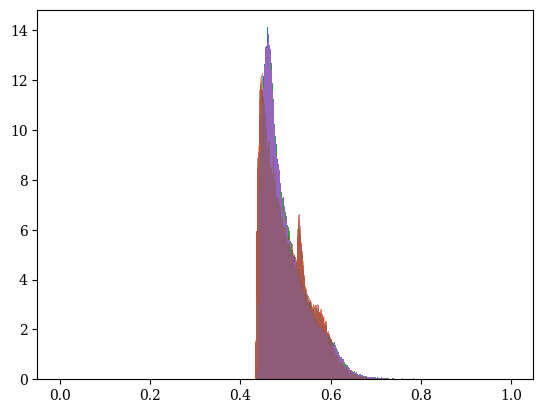

In [ ]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

_ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

In [ ]:
# view distributions of all data

# plt.figure(figsize=(10,18))
# for i in range(17):
#     plt.subplot(6,3,i+1)
#     plt.grid(False)
#     _ = plt.hist(x_train_scaled[:,i],bins=np.linspace(-5,5,512),density=True)
#     plt.title(str(header[i]))

# plt.subplots_adjust(hspace=.2)


This cell finds the ratio of samples from each model.

In [ ]:
scale = np.sum(y_train)/np.sum(1 - y_train)

print('Current prior model ratio (model 1/model 0): ',
      scale,
      flush=True)




Current prior model ratio (model 1/model 0):  1.6371525345508187


## Define functions for network

In [ ]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [ ]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=2)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net

In [ ]:
histories,results = [],[]

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 100
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######


with tf.device('/device:GPU:0'):

    # make an objective function to find the optimum layer width
    def objective(trial):
        """
        runs parameter tuning tests
        """
        dense_model = DenseNetwork(N, weight_init='he_normal',
                                            layer_width=trial.suggest_int('layer_width',5,70),
                                            added_layers=trial.suggest_int('added_layers',0,9),
                                            learning_rate=trial.suggest_float('learning_rate',1e-6,1e-2),
                                            decay_rate=trial.suggest_float('learning_rate',0.5, 1),
                                            batch_norm_flag=1)
        dense_model = dense_model.model()

        # metric to be monitored by optuna.
        monitor = 'val_loss'


        # Create callbacks for early stopping and pruning.
        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=8),
        TFKerasPruningCallback(trial, monitor),
        ]



        histories.append(dense_model.fit(x_train_scaled,y_train,
                                                        epochs=epochs,
                                                        batch_size=500,
                                                        shuffle=True,
                                                        validation_data = (x_val_scaled, y_val),
                                                        callbacks = callbacks,
                                                        verbose=1))




        gc.collect()

        # request to keep colab alive
        requests.get('https://www.google.com')

        return histories[-1].history[monitor][-1]


## Optuna
An objective function is defined above to optimize the network layer width and number of layers.

In [ ]:
# Create a study object and optimize the objective function.
study = optuna.create_study(study_name = '07_lr_lw_al', direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=200)


# Create a dataframe from the study.
df = study.trials_dataframe()

print(study.best_params)

[I 2023-07-08 17:43:34,197] A new study created in memory with name: 07_lr_lw_al


Hyper-parameters: 2 he_normal 38 0 0.009722080826320159 0.95 1 0
Epoch 1/100
640/640 [==============================] - 4s 5ms/step - loss: 0.8131 - lr: 0.0097 - val_loss: 0.8527 - val_lr: 0.0097
Epoch 2/100
640/640 [==============================] - 2s 4ms/step - loss: 0.8260 - lr: 0.0096 - val_loss: 0.8203 - val_lr: 0.0096
Epoch 3/100
640/640 [==============================] - 2s 4ms/step - loss: 0.8147 - lr: 0.0096 - val_loss: 0.8164 - val_lr: 0.0095
Epoch 4/100
640/640 [==============================] - 2s 4ms/step - loss: 0.7991 - lr: 0.0095 - val_loss: 0.8032 - val_lr: 0.0095
Epoch 5/100
640/640 [==============================] - 2s 4ms/step - loss: 0.7961 - lr: 0.0094 - val_loss: 0.8781 - val_lr: 0.0094
Epoch 6/100
640/640 [==============================] - 3s 5ms/step - loss: 0.7941 - lr: 0.0094 - val_loss: 0.8520 - val_lr: 0.0093
Epoch 7/100
640/640 [==============================] - 4s 6ms/step - loss: 0.7925 - lr: 0.0093 - val_loss: 0.7985 - val_lr: 0.0093
Epoch 8/100
640/64

[I 2023-07-08 17:44:19,910] Trial 0 finished with value: 0.8235092759132385 and parameters: {'layer_width': 38, 'added_layers': 0, 'learning_rate': 0.009722080826320159}. Best is trial 0 with value: 0.8235092759132385.


Hyper-parameters: 2 he_normal 61 4 0.007563293997499077 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.8052 - lr: 0.0075 - val_loss: 0.9962 - val_lr: 0.0075
Epoch 2/100
640/640 [==============================] - 5s 7ms/step - loss: 4.5558 - lr: 0.0075 - val_loss: 0.8692 - val_lr: 0.0075
Epoch 3/100
640/640 [==============================] - 5s 9ms/step - loss: 0.8294 - lr: 0.0074 - val_loss: 0.8132 - val_lr: 0.0074
Epoch 4/100
640/640 [==============================] - 6s 10ms/step - loss: 0.8008 - lr: 0.0074 - val_loss: 0.8249 - val_lr: 0.0074
Epoch 5/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7913 - lr: 0.0073 - val_loss: 0.7936 - val_lr: 0.0073
Epoch 6/100
640/640 [==============================] - 5s 9ms/step - loss: 0.7871 - lr: 0.0073 - val_loss: 0.8928 - val_lr: 0.0073
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7859 - lr: 0.0072 - val_loss: 0.8348 - val_lr: 0.0072
Epoch 8/100
64

[I 2023-07-08 17:46:45,107] Trial 1 finished with value: 0.7927812337875366 and parameters: {'layer_width': 61, 'added_layers': 4, 'learning_rate': 0.007563293997499077}. Best is trial 1 with value: 0.7927812337875366.


Hyper-parameters: 2 he_normal 7 6 0.004144548443024531 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.8071 - lr: 0.0041 - val_loss: 0.9089 - val_lr: 0.0041
Epoch 2/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7901 - lr: 0.0041 - val_loss: 0.8145 - val_lr: 0.0041
Epoch 3/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7866 - lr: 0.0041 - val_loss: 0.9037 - val_lr: 0.0041
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7869 - lr: 0.0041 - val_loss: 0.8070 - val_lr: 0.0040
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7860 - lr: 0.0040 - val_loss: 0.8067 - val_lr: 0.0040
Epoch 6/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7855 - lr: 0.0040 - val_loss: 0.8159 - val_lr: 0.0040
Epoch 7/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7851 - lr: 0.0040 - val_loss: 1.2846 - val_lr: 0.0040
Epoch 8/10

[I 2023-07-08 17:49:11,705] Trial 2 finished with value: 1.2103009223937988 and parameters: {'layer_width': 7, 'added_layers': 6, 'learning_rate': 0.004144548443024531}. Best is trial 1 with value: 0.7927812337875366.


Hyper-parameters: 2 he_normal 64 5 0.008983324331092453 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.8145 - lr: 0.0090 - val_loss: 0.8569 - val_lr: 0.0089
Epoch 2/100
640/640 [==============================] - 5s 8ms/step - loss: 0.8009 - lr: 0.0089 - val_loss: 0.8314 - val_lr: 0.0089
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7940 - lr: 0.0088 - val_loss: 0.7977 - val_lr: 0.0088
Epoch 4/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7976 - lr: 0.0088 - val_loss: 0.8041 - val_lr: 0.0088
Epoch 5/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7886 - lr: 0.0087 - val_loss: 0.8228 - val_lr: 0.0087
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7892 - lr: 0.0087 - val_loss: 0.7936 - val_lr: 0.0086
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7891 - lr: 0.0086 - val_loss: 0.7905 - val_lr: 0.0086
Epoch 8/100


[I 2023-07-08 17:51:37,339] Trial 3 finished with value: 0.8147878646850586 and parameters: {'layer_width': 64, 'added_layers': 5, 'learning_rate': 0.008983324331092453}. Best is trial 1 with value: 0.7927812337875366.


Hyper-parameters: 2 he_normal 5 1 0.009523411202030789 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.8273 - lr: 0.0095 - val_loss: 1.1345 - val_lr: 0.0095
Epoch 2/100
640/640 [==============================] - 3s 5ms/step - loss: 0.8066 - lr: 0.0094 - val_loss: 0.8077 - val_lr: 0.0094
Epoch 3/100
640/640 [==============================] - 3s 5ms/step - loss: 0.7999 - lr: 0.0094 - val_loss: 0.8129 - val_lr: 0.0093
Epoch 4/100
640/640 [==============================] - 3s 5ms/step - loss: 0.7955 - lr: 0.0093 - val_loss: 0.7971 - val_lr: 0.0093
Epoch 5/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7936 - lr: 0.0092 - val_loss: 0.8360 - val_lr: 0.0092
Epoch 6/100
640/640 [==============================] - 4s 6ms/step - loss: 0.8039 - lr: 0.0092 - val_loss: 1.0303 - val_lr: 0.0092
Epoch 7/100
640/640 [==============================] - 3s 5ms/step - loss: 0.8130 - lr: 0.0091 - val_loss: 0.8661 - val_lr: 0.0091
Epoch 8/100
640/640

[I 2023-07-08 17:52:20,986] Trial 4 finished with value: 0.8116000294685364 and parameters: {'layer_width': 5, 'added_layers': 1, 'learning_rate': 0.009523411202030789}. Best is trial 1 with value: 0.7927812337875366.


Hyper-parameters: 2 he_normal 18 8 0.009168229723837457 0.95 1 0
Epoch 1/100
640/640 [==============================] - 13s 16ms/step - loss: 0.8059 - lr: 0.0091 - val_loss: 0.8350 - val_lr: 0.0091
Epoch 2/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7887 - lr: 0.0091 - val_loss: 0.8134 - val_lr: 0.0090
Epoch 3/100
640/640 [==============================] - ETA: 0s - loss: 0.7891 - lr: 0.0090

[I 2023-07-08 17:52:52,173] Trial 5 pruned. Trial was pruned at epoch 2.


Hyper-parameters: 2 he_normal 36 0 0.0010307303969610598 0.95 1 0
Epoch 1/100
640/640 [==============================] - 3s 4ms/step - loss: 0.8191 - lr: 0.0010 - val_loss: 0.8220 - val_lr: 0.0010
Epoch 2/100
640/640 [==============================] - 2s 4ms/step - loss: 0.7987 - lr: 0.0010 - val_loss: 0.8034 - val_lr: 0.0010
Epoch 3/100
640/640 [==============================] - 3s 5ms/step - loss: 0.7941 - lr: 0.0010 - val_loss: 0.7991 - val_lr: 0.0010
Epoch 4/100
640/640 [==============================] - 3s 5ms/step - loss: 0.7942 - lr: 0.0010 - val_loss: 0.7967 - val_lr: 0.0010
Epoch 5/100
640/640 [==============================] - 3s 4ms/step - loss: 0.7907 - lr: 0.0010 - val_loss: 0.7976 - val_lr: 9.9744e-04
Epoch 6/100
640/640 [==============================] - 2s 4ms/step - loss: 0.7902 - lr: 9.9417e-04 - val_loss: 0.8007 - val_lr: 9.9091e-04
Epoch 7/100
640/640 [==============================] - 2s 4ms/step - loss: 0.7924 - lr: 9.8767e-04 - val_loss: 5.8562 - val_lr: 9.8443e-

[I 2023-07-08 17:54:15,155] Trial 6 finished with value: 0.7920997738838196 and parameters: {'layer_width': 36, 'added_layers': 0, 'learning_rate': 0.0010307303969610598}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 43 2 0.005643093857181386 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 15.8261 - lr: 0.0056

[I 2023-07-08 17:54:20,671] Trial 7 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 17 1 0.009868175629155276 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.9601 - lr: 0.0098

[I 2023-07-08 17:54:26,217] Trial 8 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 9 0.0073525353869029735 0.95 1 0
Epoch 1/100
640/640 [==============================] - 14s 15ms/step - loss: 0.8291 - lr: 0.0073 - val_loss: 0.8285 - val_lr: 0.0073
Epoch 2/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7902 - lr: 0.0073 - val_loss: 0.8035 - val_lr: 0.0073
Epoch 3/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7893 - lr: 0.0072 - val_loss: 0.8053 - val_lr: 0.0072
Epoch 4/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7878 - lr: 0.0072 - val_loss: 0.8007 - val_lr: 0.0072
Epoch 5/100
640/640 [==============================] - 11s 17ms/step - loss: 0.7915 - lr: 0.0071 - val_loss: 0.8428 - val_lr: 0.0071
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7897 - lr: 0.0071 - val_loss: 0.8428 - val_lr: 0.0071
Epoch 7/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7933 - lr: 0.0070 - val_loss: 0.7959 - val_lr: 0.0070
Epoch

[I 2023-07-08 17:57:53,278] Trial 9 finished with value: 0.9099689722061157 and parameters: {'layer_width': 64, 'added_layers': 9, 'learning_rate': 0.0073525353869029735}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 49 3 4.346573400067005e-05 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8870 - lr: 4.3323e-05

[I 2023-07-08 17:58:00,348] Trial 10 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 53 4 0.00010581632136268603 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8333 - lr: 1.0547e-04

[I 2023-07-08 17:58:08,852] Trial 11 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 27 7 0.002692968570570368 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.8354 - lr: 0.0027 - val_loss: 0.8401 - val_lr: 0.0027
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7862 - lr: 0.0027 - val_loss: 0.7874 - val_lr: 0.0027
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7851 - lr: 0.0026 - val_loss: 0.7917 - val_lr: 0.0026
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7847 - lr: 0.0026 - val_loss: 0.8030 - val_lr: 0.0026
Epoch 5/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7842 - lr: 0.0026 - val_loss: 0.7907 - val_lr: 0.0026
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7841 - lr: 0.0026 - val_loss: 0.8022 - val_lr: 0.0026
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7838 - lr: 0.0026 - val_loss: 0.7920 - val_lr: 0.0026
Epoch 8/10

[I 2023-07-08 17:59:37,153] Trial 12 finished with value: 0.8460124135017395 and parameters: {'layer_width': 27, 'added_layers': 7, 'learning_rate': 0.002692968570570368}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 31 3 0.006667808136475976 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.8196 - lr: 0.0066 - val_loss: 0.8377 - val_lr: 0.0066
Epoch 2/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7907 - lr: 0.0066 - val_loss: 0.8005 - val_lr: 0.0066
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7880 - lr: 0.0066 - val_loss: 0.8242 - val_lr: 0.0065
Epoch 4/100
640/640 [==============================] - 4s 6ms/step - loss: 0.7867 - lr: 0.0065 - val_loss: 0.9600 - val_lr: 0.0065
Epoch 5/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7865 - lr: 0.0065 - val_loss: 0.7990 - val_lr: 0.0065
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7858 - lr: 0.0064 - val_loss: 0.7957 - val_lr: 0.0064
Epoch 7/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7866 - lr: 0.0064 - val_loss: 0.8321 - val_lr: 0.0064
Epoch 8/100
640/64

[I 2023-07-08 18:02:01,241] Trial 13 finished with value: 0.8041035532951355 and parameters: {'layer_width': 31, 'added_layers': 3, 'learning_rate': 0.006667808136475976}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 52 5 0.002345484883662402 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.8008 - lr: 0.0023 - val_loss: 0.8370 - val_lr: 0.0023
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7952 - lr: 0.0023 - val_loss: 0.7918 - val_lr: 0.0023
Epoch 3/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7931 - lr: 0.0023 - val_loss: 0.7953 - val_lr: 0.0023
Epoch 4/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7854 - lr: 0.0023 - val_loss: 0.7945 - val_lr: 0.0023
Epoch 5/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7857 - lr: 0.0023 - val_loss: 0.7929 - val_lr: 0.0023
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7852 - lr: 0.0023 - val_loss: 0.7927 - val_lr: 0.0023
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7855 - lr: 0.0022 - val_loss: 0.7956 - val_lr: 0.0022
Epoch 8/100
640

[I 2023-07-08 18:04:03,798] Trial 14 finished with value: 0.8035710453987122 and parameters: {'layer_width': 52, 'added_layers': 5, 'learning_rate': 0.002345484883662402}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 69 0 0.007571848501062387 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8207 - lr: 0.0075

[I 2023-07-08 18:04:07,180] Trial 15 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 29 3 0.004863424737940778 0.95 1 0
Epoch 1/100
640/640 [==============================] - 7s 9ms/step - loss: 0.8342 - lr: 0.0048 - val_loss: 0.8460 - val_lr: 0.0048
Epoch 2/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7901 - lr: 0.0048 - val_loss: 0.7882 - val_lr: 0.0048
Epoch 3/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7938 - lr: 0.0048 - val_loss: 112705.8672 - val_lr: 0.0048
Epoch 4/100
640/640 [==============================] - 5s 8ms/step - loss: 0.8082 - lr: 0.0048 - val_loss: 0.8190 - val_lr: 0.0047
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7872 - lr: 0.0047 - val_loss: 0.8222 - val_lr: 0.0047
Epoch 6/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7854 - lr: 0.0047 - val_loss: 0.7969 - val_lr: 0.0047
Epoch 7/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7857 - lr: 0.0047 - val_loss: 0.7897 - val_lr: 0.0046
Epoch 8/100
6

[I 2023-07-08 18:06:31,174] Trial 16 finished with value: 0.9646934866905212 and parameters: {'layer_width': 29, 'added_layers': 3, 'learning_rate': 0.004863424737940778}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 44 6 0.0036712950427436044 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.8031 - lr: 0.0037 - val_loss: 0.8291 - val_lr: 0.0036
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.8007 - lr: 0.0036

[I 2023-07-08 18:06:49,740] Trial 17 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 59 2 0.005650106852320798 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8167 - lr: 0.0056

[I 2023-07-08 18:07:01,340] Trial 18 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 4 0.0016749513494011719 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 11ms/step - loss: 0.8042 - lr: 0.0017 - val_loss: 0.8259 - val_lr: 0.0017
Epoch 2/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7919 - lr: 0.0017 - val_loss: 0.7924 - val_lr: 0.0017
Epoch 3/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7849 - lr: 0.0016 - val_loss: 0.8971 - val_lr: 0.0016
Epoch 4/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7838 - lr: 0.0016 - val_loss: 0.8257 - val_lr: 0.0016
Epoch 5/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7842 - lr: 0.0016 - val_loss: 0.8064 - val_lr: 0.0016
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7840 - lr: 0.0016 - val_loss: 0.8165 - val_lr: 0.0016
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7839 - lr: 0.0016 - val_loss: 0.8133 - val_lr: 0.0016
Epoch 8/100
64

[I 2023-07-08 18:08:00,646] Trial 19 finished with value: 0.8112947940826416 and parameters: {'layer_width': 37, 'added_layers': 4, 'learning_rate': 0.0016749513494011719}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 23 1 0.008375465337014849 0.95 1 0
Epoch 1/100
631/640 [============================>.] - ETA: 0s - loss: 1406.1687 - lr: 0.0083

[I 2023-07-08 18:08:05,010] Trial 20 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 54 5 0.0015029527211331323 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7971 - lr: 0.0015 - val_loss: 0.8310 - val_lr: 0.0015
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7893 - lr: 0.0015

[I 2023-07-08 18:08:23,627] Trial 21 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 57 6 0.002963524414494338 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 10ms/step - loss: 0.8000 - lr: 0.0030 - val_loss: 0.8313 - val_lr: 0.0029
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7918 - lr: 0.0029

[I 2023-07-08 18:08:48,527] Trial 22 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 45 7 0.0014462087299447353 0.95 1 0
Epoch 1/100
640/640 [==============================] - 13s 15ms/step - loss: 0.7935 - lr: 0.0014 - val_loss: 0.8300 - val_lr: 0.0014
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7957 - lr: 0.0014

[I 2023-07-08 18:09:13,986] Trial 23 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 35 4 0.002434311895103184 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8007 - lr: 0.0024

[I 2023-07-08 18:09:26,060] Trial 24 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 5 0.0009810638130252768 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 10ms/step - loss: 0.7941 - lr: 9.7785e-04 - val_loss: 0.8290 - val_lr: 9.7464e-04
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7861 - lr: 9.7145e-04

[I 2023-07-08 18:09:49,498] Trial 25 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 50 2 0.003836686056214839 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.8940 - lr: 0.0038 - val_loss: 0.8316 - val_lr: 0.0038
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7927 - lr: 0.0038

[I 2023-07-08 18:10:07,693] Trial 26 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 63 7 0.0021357991172074337 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.8017 - lr: 0.0021 - val_loss: 0.8311 - val_lr: 0.0021
Epoch 2/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7865 - lr: 0.0021 - val_loss: 0.7933 - val_lr: 0.0021
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7855 - lr: 0.0021 - val_loss: 0.7937 - val_lr: 0.0021
Epoch 4/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7862 - lr: 0.0021 - val_loss: 0.7965 - val_lr: 0.0021
Epoch 5/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7867 - lr: 0.0021 - val_loss: 0.8353 - val_lr: 0.0021
Epoch 6/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7918 - lr: 0.0021 - val_loss: 0.8640 - val_lr: 0.0021
Epoch 7/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7947 - lr: 0.0020 - val_loss: 0.7925 - val_lr: 0.0020
Epoch 8/1

[I 2023-07-08 18:12:55,302] Trial 27 finished with value: 0.8038727045059204 and parameters: {'layer_width': 63, 'added_layers': 7, 'learning_rate': 0.0021357991172074337}. Best is trial 6 with value: 0.7920997738838196.


Hyper-parameters: 2 he_normal 59 8 0.0007755296941185342 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7959 - lr: 7.7300e-04

[I 2023-07-08 18:13:08,534] Trial 28 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 0 0.002991787115057329 0.95 1 0
Epoch 1/100
640/640 [==============================] - 5s 6ms/step - loss: 0.8100 - lr: 0.0030 - val_loss: 0.8261 - val_lr: 0.0030
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7964 - lr: 0.0030

[I 2023-07-08 18:13:16,715] Trial 29 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 50 3 0.002201612551934912 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7978 - lr: 0.0022

[I 2023-07-08 18:13:26,636] Trial 30 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 63 7 0.002047014387539483 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 12ms/step - loss: 0.7987 - lr: 0.0020 - val_loss: 0.8400 - val_lr: 0.0020
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7995 - lr: 0.0020

[I 2023-07-08 18:13:47,727] Trial 31 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 62 9 0.0033242483216783195 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8029 - lr: 0.0033

[I 2023-07-08 18:14:06,349] Trial 32 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 6 0.004354408065606239 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 12ms/step - loss: 0.8006 - lr: 0.0043 - val_loss: 0.8137 - val_lr: 0.0043
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7956 - lr: 0.0043

[I 2023-07-08 18:14:28,118] Trial 33 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 54 8 0.002126265700365574 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7982 - lr: 0.0021

[I 2023-07-08 18:14:41,564] Trial 34 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 6 0.0008471351726841725 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 10ms/step - loss: 0.8006 - lr: 8.4436e-04 - val_loss: 0.8384 - val_lr: 8.4159e-04
Epoch 2/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7856 - lr: 8.3883e-04 - val_loss: 0.7886 - val_lr: 8.3608e-04
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7899 - lr: 8.3334e-04 - val_loss: 0.7950 - val_lr: 8.3061e-04
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7852 - lr: 8.2789e-04 - val_loss: 0.7873 - val_lr: 8.2518e-04
Epoch 5/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7837 - lr: 8.2247e-04 - val_loss: 0.7878 - val_lr: 8.1978e-04
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7833 - lr: 8.1709e-04 - val_loss: 0.7875 - val_lr: 8.1441e-04
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7833 - lr: 8.1174

[I 2023-07-08 18:17:06,608] Trial 35 finished with value: 0.7881984114646912 and parameters: {'layer_width': 65, 'added_layers': 6, 'learning_rate': 0.0008471351726841725}. Best is trial 35 with value: 0.7881984114646912.


Hyper-parameters: 2 he_normal 67 6 0.0007483888390004982 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 14ms/step - loss: 0.7946 - lr: 7.4593e-04 - val_loss: 0.8215 - val_lr: 7.4349e-04
Epoch 2/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7864 - lr: 7.4105e-04 - val_loss: 0.7932 - val_lr: 7.3863e-04
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7853 - lr: 7.3620e-04 - val_loss: 0.7996 - val_lr: 7.3379e-04
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7852 - lr: 7.3138e-04 - val_loss: 0.7903 - val_lr: 7.2899e-04
Epoch 5/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7838 - lr: 7.2660e-04 - val_loss: 0.7904 - val_lr: 7.2422e-04
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7845 - lr: 7.2184e-04 - val_loss: 0.7900 - val_lr: 7.1948e-04
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7834 - lr: 7.17

[I 2023-07-08 18:19:49,860] Trial 36 finished with value: 0.8214553594589233 and parameters: {'layer_width': 67, 'added_layers': 6, 'learning_rate': 0.0007483888390004982}. Best is trial 35 with value: 0.7881984114646912.


Hyper-parameters: 2 he_normal 33 5 0.0012843614561339953 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.8031 - lr: 0.0013 - val_loss: 0.8347 - val_lr: 0.0013
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7856 - lr: 0.0013 - val_loss: 0.7960 - val_lr: 0.0013
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7842 - lr: 0.0013 - val_loss: 0.7891 - val_lr: 0.0013
Epoch 4/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7839 - lr: 0.0013 - val_loss: 0.7881 - val_lr: 0.0013
Epoch 5/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7833 - lr: 0.0012 - val_loss: 0.8442 - val_lr: 0.0012
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7837 - lr: 0.0012 - val_loss: 0.7856 - val_lr: 0.0012
Epoch 7/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7835 - lr: 0.0012 - val_loss: 0.7882 - val_lr: 0.0012
Epoch 8/100
6

[I 2023-07-08 18:22:14,520] Trial 37 finished with value: 0.7969339489936829 and parameters: {'layer_width': 33, 'added_layers': 5, 'learning_rate': 0.0012843614561339953}. Best is trial 35 with value: 0.7881984114646912.


Hyper-parameters: 2 he_normal 33 5 0.0005110691528908209 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 11ms/step - loss: 0.8019 - lr: 5.0939e-04 - val_loss: 0.8294 - val_lr: 5.0772e-04
Epoch 2/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7860 - lr: 5.0606e-04 - val_loss: 0.7904 - val_lr: 5.0440e-04
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7843 - lr: 5.0275e-04 - val_loss: 0.8083 - val_lr: 5.0110e-04
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7846 - lr: 4.9946e-04 - val_loss: 0.7899 - val_lr: 4.9782e-04
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7840 - lr: 4.9619e-04 - val_loss: 0.7906 - val_lr: 4.9456e-04
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7832 - lr: 4.9294e-04 - val_loss: 0.8007 - val_lr: 4.9133e-04
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7833 - lr: 4.8972e-

[I 2023-07-08 18:27:10,134] Trial 38 finished with value: 0.7852069139480591 and parameters: {'layer_width': 33, 'added_layers': 5, 'learning_rate': 0.0005110691528908209}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 23 4 0.0005616233900761561 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8071 - lr: 5.5978e-04

[I 2023-07-08 18:27:18,105] Trial 39 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 10 6 0.0003459731109179088 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.9172 - lr: 3.4484e-04

[I 2023-07-08 18:27:29,516] Trial 40 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 5 0.0011983530116951603 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.8140 - lr: 0.0012 - val_loss: 0.8203 - val_lr: 0.0012
Epoch 2/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7877 - lr: 0.0012 - val_loss: 0.7879 - val_lr: 0.0012
Epoch 3/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7844 - lr: 0.0012 - val_loss: 0.7930 - val_lr: 0.0012
Epoch 4/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7839 - lr: 0.0012 - val_loss: 0.7909 - val_lr: 0.0012
Epoch 5/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7831 - lr: 0.0012 - val_loss: 0.7907 - val_lr: 0.0012
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7837 - lr: 0.0012 - val_loss: 0.7884 - val_lr: 0.0012
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7839 - lr: 0.0011 - val_loss: 0.7969 - val_lr: 0.0011
Epoch 8/100
64

[I 2023-07-08 18:28:55,754] Trial 41 finished with value: 0.7921149730682373 and parameters: {'layer_width': 33, 'added_layers': 5, 'learning_rate': 0.0011983530116951603}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 39 5 0.0009946442624657748 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8048 - lr: 9.9140e-04

[I 2023-07-08 18:29:04,671] Trial 42 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 24 4 2.9908327107166805e-05 0.95 1 0
Epoch 1/100
633/640 [============================>.] - ETA: 0s - loss: 0.9789 - lr: 2.9811e-05

[I 2023-07-08 18:29:13,262] Trial 43 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 18 1 0.0005034384850318178 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8337 - lr: 5.0179e-04

[I 2023-07-08 18:29:17,532] Trial 44 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 5 0.001099080546276089 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 10ms/step - loss: 0.7997 - lr: 0.0011 - val_loss: 0.8205 - val_lr: 0.0011
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7860 - lr: 0.0011

[I 2023-07-08 18:29:34,945] Trial 45 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 46 3 0.001644340474957297 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.7976 - lr: 0.0016 - val_loss: 0.8366 - val_lr: 0.0016
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7891 - lr: 0.0016 - val_loss: 0.7926 - val_lr: 0.0016
Epoch 3/100
640/640 [==============================] - 4s 6ms/step - loss: 0.7853 - lr: 0.0016 - val_loss: 0.7927 - val_lr: 0.0016
Epoch 4/100
640/640 [==============================] - 4s 6ms/step - loss: 0.7864 - lr: 0.0016 - val_loss: 0.7964 - val_lr: 0.0016
Epoch 5/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7841 - lr: 0.0016 - val_loss: 0.7885 - val_lr: 0.0016
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7842 - lr: 0.0016 - val_loss: 0.7906 - val_lr: 0.0016
Epoch 7/100
640/640 [==============================] - 4s 6ms/step - loss: 0.7843 - lr: 0.0016 - val_loss: 0.8040 - val_lr: 0.0016
Epoch 8/100
640/64

[I 2023-07-08 18:30:51,821] Trial 46 finished with value: 0.7948407530784607 and parameters: {'layer_width': 46, 'added_layers': 3, 'learning_rate': 0.001644340474957297}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 28 2 0.00040885065081881013 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8203 - lr: 4.0752e-04

[I 2023-07-08 18:30:57,463] Trial 47 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 31 6 1.3992013405885015e-05 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.9519 - lr: 1.3946e-05

[I 2023-07-08 18:31:09,204] Trial 48 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 4 0.0012345327053184707 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 11ms/step - loss: 0.7945 - lr: 0.0012 - val_loss: 0.8263 - val_lr: 0.0012
Epoch 2/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7869 - lr: 0.0012 - val_loss: 0.7877 - val_lr: 0.0012
Epoch 3/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7847 - lr: 0.0012 - val_loss: 0.7896 - val_lr: 0.0012
Epoch 4/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7840 - lr: 0.0012 - val_loss: 0.8040 - val_lr: 0.0012
Epoch 5/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7847 - lr: 0.0012 - val_loss: 0.7936 - val_lr: 0.0012
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7830 - lr: 0.0012 - val_loss: 0.7947 - val_lr: 0.0012
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7831 - lr: 0.0012 - val_loss: 0.7983 - val_lr: 0.0012
Epoch 8/100
6

[I 2023-07-08 18:32:33,555] Trial 49 finished with value: 0.7931134104728699 and parameters: {'layer_width': 41, 'added_layers': 4, 'learning_rate': 0.0012345327053184707}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 38 0 0.001903052744003797 0.95 1 0
Epoch 1/100
631/640 [============================>.] - ETA: 0s - loss: 0.8093 - lr: 0.0019

[I 2023-07-08 18:32:38,268] Trial 50 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 4 0.001224194604352046 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7958 - lr: 0.0012

[I 2023-07-08 18:32:47,394] Trial 51 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 26 5 0.001726728612381137 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7986 - lr: 0.0017

[I 2023-07-08 18:32:57,525] Trial 52 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 31 3 0.0008233847005511773 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8028 - lr: 8.2069e-04

[I 2023-07-08 18:33:04,053] Trial 53 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 4 0.0012903957579269965 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 9ms/step - loss: 0.7951 - lr: 0.0013 - val_loss: 0.8171 - val_lr: 0.0013
Epoch 2/100
635/640 [============================>.] - ETA: 0s - loss: 0.7868 - lr: 0.0013

[I 2023-07-08 18:33:17,725] Trial 54 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 47 5 0.0016709709156148762 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.7963 - lr: 0.0017 - val_loss: 0.8211 - val_lr: 0.0017
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7862 - lr: 0.0017 - val_loss: 0.7919 - val_lr: 0.0016
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7842 - lr: 0.0016 - val_loss: 0.8053 - val_lr: 0.0016
Epoch 4/100
640/640 [==============================] - 5s 9ms/step - loss: 0.7845 - lr: 0.0016 - val_loss: 0.8202 - val_lr: 0.0016
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7849 - lr: 0.0016 - val_loss: 0.8426 - val_lr: 0.0016
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7845 - lr: 0.0016 - val_loss: 0.8241 - val_lr: 0.0016
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7843 - lr: 0.0016 - val_loss: 0.8098 - val_lr: 0.0016
Epoch 8/100
6

[I 2023-07-08 18:34:26,166] Trial 55 finished with value: 0.8106204867362976 and parameters: {'layer_width': 47, 'added_layers': 5, 'learning_rate': 0.0016709709156148762}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 35 8 0.00042800104243845803 0.95 1 0
Epoch 1/100
640/640 [==============================] - 13s 12ms/step - loss: 0.8011 - lr: 4.2660e-04 - val_loss: 0.8304 - val_lr: 4.2520e-04
Epoch 2/100
640/640 [==============================] - 9s 15ms/step - loss: 0.7865 - lr: 4.2381e-04 - val_loss: 0.7909 - val_lr: 4.2242e-04
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7847 - lr: 4.2103e-04 - val_loss: 0.7926 - val_lr: 4.1965e-04
Epoch 4/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7838 - lr: 4.1828e-04 - val_loss: 0.7996 - val_lr: 4.1691e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7835 - lr: 4.1554e-04 - val_loss: 0.7871 - val_lr: 4.1418e-04
Epoch 6/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7828 - lr: 4.1282e-04 - val_loss: 0.7944 - val_lr: 4.1147e-04
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7825 - lr: 4

[I 2023-07-08 18:37:27,229] Trial 56 finished with value: 0.7921566367149353 and parameters: {'layer_width': 35, 'added_layers': 8, 'learning_rate': 0.00042800104243845803}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 35 7 0.0003482983243879214 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.8096 - lr: 3.4716e-04 - val_loss: 0.8178 - val_lr: 3.4602e-04
Epoch 2/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7849 - lr: 3.4488e-04 - val_loss: 0.7917 - val_lr: 3.4375e-04
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7836 - lr: 3.4263e-04 - val_loss: 0.7968 - val_lr: 3.4150e-04
Epoch 4/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7832 - lr: 3.4038e-04 - val_loss: 0.7910 - val_lr: 3.3927e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7829 - lr: 3.3816e-04 - val_loss: 0.7867 - val_lr: 3.3705e-04
Epoch 6/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7823 - lr: 3.3594e-04 - val_loss: 0.7889 - val_lr: 3.3484e-04
Epoch 7/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7826 - lr: 3.33

[I 2023-07-08 18:40:52,630] Trial 57 finished with value: 0.7854111194610596 and parameters: {'layer_width': 35, 'added_layers': 7, 'learning_rate': 0.0003482983243879214}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 34 7 0.00034330358637949237 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.8074 - lr: 3.4218e-04 - val_loss: 0.8341 - val_lr: 3.4106e-04
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7846 - lr: 3.3994e-04

[I 2023-07-08 18:41:11,725] Trial 58 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 37 8 0.0007277531191723977 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7979 - lr: 7.2537e-04

[I 2023-07-08 18:41:24,000] Trial 59 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 9 0.0002888436581896912 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8154 - lr: 2.8790e-04

[I 2023-07-08 18:41:37,353] Trial 60 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 7 0.0008971263684531003 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8017 - lr: 8.9420e-04

[I 2023-07-08 18:41:48,632] Trial 61 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 6 0.0005683647493005026 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8018 - lr: 5.6650e-04

[I 2023-07-08 18:41:59,874] Trial 62 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 7 0.0014335267457497598 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.8003 - lr: 0.0014 - val_loss: 0.8266 - val_lr: 0.0014
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7870 - lr: 0.0014

[I 2023-07-08 18:42:18,711] Trial 63 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 26 8 0.0025277001193648005 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8011 - lr: 0.0025

[I 2023-07-08 18:42:33,227] Trial 64 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 32 6 0.00023276622431711772 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8126 - lr: 2.3201e-04

[I 2023-07-08 18:42:44,330] Trial 65 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 20 7 0.0010141191243356485 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8018 - lr: 0.0010

[I 2023-07-08 18:42:57,545] Trial 66 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 60 9 0.000640298831045605 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7951 - lr: 6.3820e-04

[I 2023-07-08 18:43:10,683] Trial 67 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 40 8 0.00011451585764758136 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8541 - lr: 1.1414e-04

[I 2023-07-08 18:43:23,258] Trial 68 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 44 6 0.0018080074770014402 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7975 - lr: 0.0018

[I 2023-07-08 18:43:36,413] Trial 69 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 28 7 0.006244824170276683 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8077 - lr: 0.0062

[I 2023-07-08 18:43:53,338] Trial 70 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 5 0.001471913191422775 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7969 - lr: 0.0015

[I 2023-07-08 18:44:06,032] Trial 71 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 4 0.0010223878360623492 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 10ms/step - loss: 0.7948 - lr: 0.0010 - val_loss: 0.8277 - val_lr: 0.0010
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7873 - lr: 0.0010

[I 2023-07-08 18:44:20,093] Trial 72 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 11 3 0.0012338067064161227 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8206 - lr: 0.0012

[I 2023-07-08 18:44:35,702] Trial 73 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 57 5 0.0006082689766698594 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7936 - lr: 6.0628e-04

[I 2023-07-08 18:44:45,667] Trial 74 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 1 0.0020884316548330224 0.95 1 0
Epoch 1/100
640/640 [==============================] - 4s 5ms/step - loss: 0.8031 - lr: 0.0021 - val_loss: 0.8289 - val_lr: 0.0021
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7906 - lr: 0.0021

[I 2023-07-08 18:44:53,083] Trial 75 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 48 4 0.000826025944454824 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 8ms/step - loss: 0.7946 - lr: 8.2332e-04 - val_loss: 0.8213 - val_lr: 8.2062e-04
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7854 - lr: 8.1793e-04

[I 2023-07-08 18:45:10,769] Trial 76 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 33 6 0.001413731359911547 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.7945 - lr: 0.0014 - val_loss: 0.8303 - val_lr: 0.0014
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7866 - lr: 0.0014

[I 2023-07-08 18:45:28,550] Trial 77 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 35 2 1.901620390327123e-05 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 1.0081 - lr: 1.8954e-05

[I 2023-07-08 18:45:35,511] Trial 78 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 52 8 0.002349551085573647 0.95 1 0
Epoch 1/100
640/640 [==============================] - 16s 16ms/step - loss: 0.7994 - lr: 0.0023 - val_loss: 0.8327 - val_lr: 0.0023
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7876 - lr: 0.0023

[I 2023-07-08 18:46:00,952] Trial 79 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 29 5 0.000544118935924516 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 9ms/step - loss: 0.8006 - lr: 5.4233e-04 - val_loss: 0.8155 - val_lr: 5.4056e-04
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7848 - lr: 5.3879e-04

[I 2023-07-08 18:46:16,615] Trial 80 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 46 3 0.0010812018555601335 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7980 - lr: 0.0011

[I 2023-07-08 18:46:23,964] Trial 81 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 3 0.0016234603864404094 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7977 - lr: 0.0016

[I 2023-07-08 18:46:31,419] Trial 82 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 38 4 0.0018874227693780024 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7933 - lr: 0.0019

[I 2023-07-08 18:46:43,717] Trial 83 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 44 0 0.000276084652463801 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8546 - lr: 2.7519e-04

[I 2023-07-08 18:46:48,557] Trial 84 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 4 0.0013028695296504519 0.95 1 0
Epoch 1/100
640/640 [==============================] - 7s 8ms/step - loss: 0.7944 - lr: 0.0013 - val_loss: 0.8101 - val_lr: 0.0013
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7854 - lr: 0.0013

[I 2023-07-08 18:47:01,587] Trial 85 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 57 5 0.00045199844993973966 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7984 - lr: 4.5052e-04

[I 2023-07-08 18:47:11,053] Trial 86 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 6 0.0008542071118976901 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.7936 - lr: 8.5140e-04 - val_loss: 0.8270 - val_lr: 8.4862e-04
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7866 - lr: 8.4584e-04

[I 2023-07-08 18:47:28,333] Trial 87 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 65 2 0.0016307982997449835 0.95 1 0
Epoch 1/100
634/640 [============================>.] - ETA: 0s - loss: 0.7945 - lr: 0.0016

[I 2023-07-08 18:47:34,428] Trial 88 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 1 0.0011191975064066746 0.95 1 0
Epoch 1/100
640/640 [==============================] - 5s 5ms/step - loss: 0.7982 - lr: 0.0011 - val_loss: 0.8232 - val_lr: 0.0011
Epoch 2/100
632/640 [============================>.] - ETA: 0s - loss: 0.7876 - lr: 0.0011

[I 2023-07-08 18:47:42,837] Trial 89 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 61 4 0.0026778243251227617 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 8ms/step - loss: 0.7982 - lr: 0.0027 - val_loss: 0.8188 - val_lr: 0.0027
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.8037 - lr: 0.0027

[I 2023-07-08 18:48:02,207] Trial 90 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 32 5 0.0007510894791524817 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 13ms/step - loss: 0.7966 - lr: 7.4863e-04 - val_loss: 0.8112 - val_lr: 7.4618e-04
Epoch 2/100
635/640 [============================>.] - ETA: 0s - loss: 0.7847 - lr: 7.4375e-04

[I 2023-07-08 18:48:30,035] Trial 91 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 36 5 0.0012046520344218574 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7942 - lr: 0.0012

[I 2023-07-08 18:48:40,475] Trial 92 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 5 0.0014727206235356674 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7999 - lr: 0.0015

[I 2023-07-08 18:48:49,120] Trial 93 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 6 0.00029260002936793653 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8190 - lr: 2.9164e-04

[I 2023-07-08 18:49:02,459] Trial 94 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 3 0.0009612953367571018 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.7972 - lr: 9.5814e-04 - val_loss: 0.8283 - val_lr: 9.5501e-04
Epoch 2/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7887 - lr: 9.5187e-04 - val_loss: 0.7902 - val_lr: 9.4876e-04
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7844 - lr: 9.4564e-04 - val_loss: 0.7976 - val_lr: 9.4254e-04
Epoch 4/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7846 - lr: 9.3945e-04 - val_loss: 0.7880 - val_lr: 9.3638e-04
Epoch 5/100
640/640 [==============================] - 4s 7ms/step - loss: 0.7836 - lr: 9.3331e-04 - val_loss: 0.7910 - val_lr: 9.3025e-04
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7836 - lr: 9.2720e-04 - val_loss: 0.7887 - val_lr: 9.2416e-04
Epoch 7/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7827 - lr: 9.2113e-04 -

[I 2023-07-08 18:50:35,789] Trial 95 finished with value: 0.7880578637123108 and parameters: {'layer_width': 37, 'added_layers': 3, 'learning_rate': 0.0009612953367571018}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 40 3 0.0008804666676145871 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7980 - lr: 8.7758e-04

[I 2023-07-08 18:50:44,556] Trial 96 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 3 0.0004901568850588615 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8316 - lr: 4.8855e-04

[I 2023-07-08 18:50:55,490] Trial 97 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 3 0.0018875949927200963 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7974 - lr: 0.0019

[I 2023-07-08 18:51:03,179] Trial 98 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 4 0.00017908300617489324 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8197 - lr: 1.7850e-04

[I 2023-07-08 18:51:13,465] Trial 99 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 50 2 0.0007130054545738891 0.95 1 0
Epoch 1/100
640/640 [==============================] - 6s 7ms/step - loss: 0.7963 - lr: 7.1067e-04 - val_loss: 0.8300 - val_lr: 7.0834e-04
Epoch 2/100
632/640 [============================>.] - ETA: 0s - loss: 0.7979 - lr: 7.0604e-04

[I 2023-07-08 18:51:23,677] Trial 100 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 38 5 0.0012744521247238436 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7942 - lr: 0.0013 - val_loss: 0.8294 - val_lr: 0.0013
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7932 - lr: 0.0013

[I 2023-07-08 18:51:39,553] Trial 101 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 31 4 0.0011094580579535031 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 11ms/step - loss: 0.8088 - lr: 0.0011 - val_loss: 0.8219 - val_lr: 0.0011
Epoch 2/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7855 - lr: 0.0011 - val_loss: 0.7910 - val_lr: 0.0011
Epoch 3/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7844 - lr: 0.0011 - val_loss: 0.7898 - val_lr: 0.0011
Epoch 4/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7834 - lr: 0.0011 - val_loss: 0.7917 - val_lr: 0.0011
Epoch 5/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7838 - lr: 0.0011 - val_loss: 0.7894 - val_lr: 0.0011
Epoch 6/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7833 - lr: 0.0011 - val_loss: 0.7941 - val_lr: 0.0011
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7834 - lr: 0.0011 - val_loss: 0.7904 - val_lr: 0.0011
Epoch 8/100
64

[I 2023-07-08 18:53:59,181] Trial 102 pruned. Trial was pruned at epoch 23.


Hyper-parameters: 2 he_normal 26 7 0.0004480185244722711 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8104 - lr: 4.4655e-04

[I 2023-07-08 18:54:09,931] Trial 103 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 5 0.001024828528100963 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.7952 - lr: 0.0010 - val_loss: 0.8167 - val_lr: 0.0010
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7853 - lr: 0.0010

[I 2023-07-08 18:54:25,752] Trial 104 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 32 6 0.0015492278095305804 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7956 - lr: 0.0015

[I 2023-07-08 18:54:46,608] Trial 105 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 29 4 0.0009383946117635715 0.95 1 0
Epoch 1/100
640/640 [==============================] - 7s 8ms/step - loss: 0.7983 - lr: 9.3532e-04 - val_loss: 0.8310 - val_lr: 9.3225e-04
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7859 - lr: 9.2920e-04 - val_loss: 0.7925 - val_lr: 9.2615e-04
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7838 - lr: 9.2311e-04 - val_loss: 0.8215 - val_lr: 9.2009e-04
Epoch 4/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7846 - lr: 9.1707e-04 - val_loss: 0.7906 - val_lr: 9.1407e-04
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7834 - lr: 9.1107e-04 - val_loss: 0.7918 - val_lr: 9.0809e-04
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7834 - lr: 9.0511e-04 - val_loss: 0.7882 - val_lr: 9.0215e-04
Epoch 7/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7823 - lr: 8.9919e-04 -

[I 2023-07-08 18:56:08,432] Trial 106 finished with value: 0.7965739965438843 and parameters: {'layer_width': 29, 'added_layers': 4, 'learning_rate': 0.0009383946117635715}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 24 4 0.0006662675649050885 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8024 - lr: 6.6410e-04

[I 2023-07-08 18:56:16,266] Trial 107 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 40 4 0.0008570748982328991 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7957 - lr: 8.5428e-04

[I 2023-07-08 18:56:28,543] Trial 108 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 27 8 0.0002063910853864722 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8477 - lr: 2.0572e-04

[I 2023-07-08 18:56:44,685] Trial 109 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 4 0.0017760077766323917 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8073 - lr: 0.0018

[I 2023-07-08 18:57:00,598] Trial 110 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 5 0.001327025256550734 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.7991 - lr: 0.0013 - val_loss: 0.8258 - val_lr: 0.0013
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7923 - lr: 0.0013

[I 2023-07-08 18:57:21,417] Trial 111 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 63 2 0.001016590339005497 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7942 - lr: 0.0010

[I 2023-07-08 18:57:34,642] Trial 112 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 4 0.0006241763071787049 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 8ms/step - loss: 0.8017 - lr: 6.2213e-04 - val_loss: 0.8184 - val_lr: 6.2009e-04
Epoch 2/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7867 - lr: 6.1806e-04 - val_loss: 0.7904 - val_lr: 6.1603e-04
Epoch 3/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7835 - lr: 6.1401e-04 - val_loss: 0.7963 - val_lr: 6.1200e-04
Epoch 4/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7837 - lr: 6.0999e-04 - val_loss: 0.8026 - val_lr: 6.0800e-04
Epoch 5/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7835 - lr: 6.0600e-04 - val_loss: 0.7873 - val_lr: 6.0402e-04
Epoch 6/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7833 - lr: 6.0204e-04 - val_loss: 0.8037 - val_lr: 6.0006e-04
Epoch 7/100
640/640 [==============================] - 5s 7ms/step - loss: 0.7829 - lr: 5.9810e-04

[I 2023-07-08 18:59:53,257] Trial 113 pruned. Trial was pruned at epoch 23.


Hyper-parameters: 2 he_normal 29 3 0.00044695179844446653 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8142 - lr: 4.4549e-04

[I 2023-07-08 19:00:06,795] Trial 114 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 9 0.0014196946981277533 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7964 - lr: 0.0014

[I 2023-07-08 19:00:23,551] Trial 115 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 5 0.000938381111639932 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7964 - lr: 9.3530e-04 - val_loss: 0.8199 - val_lr: 9.3224e-04
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7890 - lr: 9.2920e-04

[I 2023-07-08 19:00:39,760] Trial 116 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 21 6 0.00200511768244485 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 10ms/step - loss: 0.8221 - lr: 0.0020 - val_loss: 0.8248 - val_lr: 0.0020
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7885 - lr: 0.0020

[I 2023-07-08 19:01:04,369] Trial 117 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 33 4 0.002237790298339137 0.95 1 0
Epoch 1/100
640/640 [==============================] - 7s 8ms/step - loss: 0.7955 - lr: 0.0022 - val_loss: 0.8204 - val_lr: 0.0022
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7861 - lr: 0.0022

[I 2023-07-08 19:01:18,473] Trial 118 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 31 7 0.0016515166741451984 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 13ms/step - loss: 0.7982 - lr: 0.0016 - val_loss: 0.8169 - val_lr: 0.0016
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7868 - lr: 0.0016

[I 2023-07-08 19:01:46,218] Trial 119 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 43 1 7.114334693626961e-05 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8861 - lr: 7.0910e-05

[I 2023-07-08 19:01:55,583] Trial 120 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 55 5 0.001166763125878498 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 15ms/step - loss: 0.7933 - lr: 0.0012 - val_loss: 0.8143 - val_lr: 0.0012
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7894 - lr: 0.0012

[I 2023-07-08 19:02:13,555] Trial 121 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 52 5 0.000703237020044585 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8131 - lr: 7.0094e-04

[I 2023-07-08 19:02:23,407] Trial 122 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 46 5 0.0013369695325361917 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7961 - lr: 0.0013

[I 2023-07-08 19:02:32,172] Trial 123 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 59 6 0.0017396148004116087 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8023 - lr: 0.0017

[I 2023-07-08 19:02:48,379] Trial 124 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 4 0.008007397392886152 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8136 - lr: 0.0080

[I 2023-07-08 19:02:59,551] Trial 125 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 48 5 0.0015340277915906096 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.8585 - lr: 0.0015 - val_loss: 0.8299 - val_lr: 0.0015
Epoch 2/100
640/640 [==============================] - 5s 8ms/step - loss: 0.7886 - lr: 0.0015 - val_loss: 0.7893 - val_lr: 0.0015
Epoch 3/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7849 - lr: 0.0015 - val_loss: 0.7896 - val_lr: 0.0015
Epoch 4/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7841 - lr: 0.0015 - val_loss: 0.8000 - val_lr: 0.0015
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7837 - lr: 0.0015 - val_loss: 0.7906 - val_lr: 0.0015
Epoch 6/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7839 - lr: 0.0015 - val_loss: 0.7896 - val_lr: 0.0015
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7836 - lr: 0.0015 - val_loss: 0.7884 - val_lr: 0.0015
Epoch 8/100


[I 2023-07-08 19:04:39,292] Trial 126 finished with value: 0.8037148714065552 and parameters: {'layer_width': 48, 'added_layers': 5, 'learning_rate': 0.0015340277915906096}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 36 5 0.004679353329323965 0.95 1 0
Epoch 1/100
634/640 [============================>.] - ETA: 0s - loss: 0.7971 - lr: 0.0047

[I 2023-07-08 19:04:52,396] Trial 127 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 6 0.00041256824933643077 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8014 - lr: 4.1122e-04

[I 2023-07-08 19:05:04,712] Trial 128 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 8 0.0008811580840018899 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.7960 - lr: 8.7827e-04 - val_loss: 0.8175 - val_lr: 8.7539e-04
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7878 - lr: 8.7252e-04

[I 2023-07-08 19:05:27,470] Trial 129 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 41 4 0.002009061183011705 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7963 - lr: 0.0020

[I 2023-07-08 19:05:36,142] Trial 130 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 49 5 0.0011607702335445027 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.8072 - lr: 0.0012 - val_loss: 0.8300 - val_lr: 0.0012
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7892 - lr: 0.0011

[I 2023-07-08 19:05:51,494] Trial 131 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 45 5 0.0015277273979922453 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8522 - lr: 0.0015

[I 2023-07-08 19:06:00,296] Trial 132 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 47 5 0.009169149496183861 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8333 - lr: 0.0091

[I 2023-07-08 19:06:14,054] Trial 133 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 32 0 0.0038388131776891186 0.95 1 0
Epoch 1/100
630/640 [============================>.] - ETA: 0s - loss: 0.8080 - lr: 0.0038

[I 2023-07-08 19:06:17,548] Trial 134 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 51 5 0.0022719532295045995 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.7984 - lr: 0.0023 - val_loss: 0.8303 - val_lr: 0.0023
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.8080 - lr: 0.0022 - val_loss: 0.7898 - val_lr: 0.0022
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7883 - lr: 0.0022 - val_loss: 0.7968 - val_lr: 0.0022
Epoch 4/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7867 - lr: 0.0022 - val_loss: 0.8041 - val_lr: 0.0022
Epoch 5/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7903 - lr: 0.0022 - val_loss: 0.7909 - val_lr: 0.0022
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7850 - lr: 0.0022 - val_loss: 0.7922 - val_lr: 0.0022
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7845 - lr: 0.0022 - val_loss: 0.7905 - val_lr: 0.0022
Epoch 8/100
6

[I 2023-07-08 19:07:43,508] Trial 135 finished with value: 0.8120883703231812 and parameters: {'layer_width': 51, 'added_layers': 5, 'learning_rate': 0.0022719532295045995}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 48 4 0.0013690626790625947 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.7933 - lr: 0.0014 - val_loss: 0.8264 - val_lr: 0.0014
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7868 - lr: 0.0014

[I 2023-07-08 19:07:57,716] Trial 136 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 67 3 0.000627103038940579 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7987 - lr: 6.2505e-04

[I 2023-07-08 19:08:05,147] Trial 137 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 38 6 0.0009420752252095172 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7970 - lr: 9.3899e-04

[I 2023-07-08 19:08:16,882] Trial 138 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 56 7 0.0015738024932536116 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7967 - lr: 0.0016

[I 2023-07-08 19:08:27,613] Trial 139 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 4 0.0024732981736230847 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 8ms/step - loss: 0.7967 - lr: 0.0025 - val_loss: 0.8138 - val_lr: 0.0025
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7932 - lr: 0.0024

[I 2023-07-08 19:08:41,308] Trial 140 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 62 7 0.0018996493457253832 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7967 - lr: 0.0019

[I 2023-07-08 19:09:03,697] Trial 141 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 8 0.002947682869868241 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 15ms/step - loss: 0.8024 - lr: 0.0029 - val_loss: 0.8260 - val_lr: 0.0029
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7924 - lr: 0.0029

[I 2023-07-08 19:09:24,066] Trial 142 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 60 5 0.0021832582000666932 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7967 - lr: 0.0022 - val_loss: 0.8279 - val_lr: 0.0022
Epoch 2/100
635/640 [============================>.] - ETA: 0s - loss: 0.7917 - lr: 0.0022

[I 2023-07-08 19:09:39,613] Trial 143 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 33 9 0.005383794946499652 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8062 - lr: 0.0054

[I 2023-07-08 19:10:04,275] Trial 144 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 53 6 0.001208619946118732 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7966 - lr: 0.0012

[I 2023-07-08 19:10:15,098] Trial 145 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 43 5 0.0008334044811497828 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7922 - lr: 8.3067e-04

[I 2023-07-08 19:10:27,595] Trial 146 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 28 7 0.0017644389099646125 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7949 - lr: 0.0018

[I 2023-07-08 19:10:40,205] Trial 147 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 5 0.0002517130814182526 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8190 - lr: 2.5089e-04

[I 2023-07-08 19:10:50,988] Trial 148 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 62 2 0.0010225990659035343 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7974 - lr: 0.0010

[I 2023-07-08 19:10:56,729] Trial 149 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 4 0.0065008325099770465 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8006 - lr: 0.0065

[I 2023-07-08 19:11:04,818] Trial 150 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 3 0.0014318677192241998 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7988 - lr: 0.0014

[I 2023-07-08 19:11:12,077] Trial 151 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 32 3 0.0005353893240530333 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8040 - lr: 5.3364e-04

[I 2023-07-08 19:11:18,619] Trial 152 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 29 3 0.007298006197135413 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 8ms/step - loss: 0.8086 - lr: 0.0073 - val_loss: 0.8127 - val_lr: 0.0073
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.8020 - lr: 0.0072

[I 2023-07-08 19:11:32,993] Trial 153 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 31 4 0.0007709239433185516 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7991 - lr: 7.6841e-04

[I 2023-07-08 19:11:42,776] Trial 154 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 58 3 0.0011889532198851244 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 10ms/step - loss: 0.7967 - lr: 0.0012 - val_loss: 0.8294 - val_lr: 0.0012
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7891 - lr: 0.0012

[I 2023-07-08 19:12:00,560] Trial 155 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 36 2 0.0016610568033203583 0.95 1 0
Epoch 1/100
631/640 [============================>.] - ETA: 0s - loss: 0.7990 - lr: 0.0017

[I 2023-07-08 19:12:15,413] Trial 156 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 6 0.00034640014649786843 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.7979 - lr: 3.4526e-04 - val_loss: 0.8299 - val_lr: 3.4413e-04
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7856 - lr: 3.4300e-04 - val_loss: 0.7871 - val_lr: 3.4188e-04
Epoch 3/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7842 - lr: 3.4076e-04 - val_loss: 0.7956 - val_lr: 3.3964e-04
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7837 - lr: 3.3853e-04 - val_loss: 0.7887 - val_lr: 3.3742e-04
Epoch 5/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7826 - lr: 3.3631e-04 - val_loss: 0.7957 - val_lr: 3.3521e-04
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7830 - lr: 3.3411e-04 - val_loss: 0.7947 - val_lr: 3.3302e-04
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7830 - lr: 3.319

[I 2023-07-08 19:14:19,161] Trial 157 finished with value: 0.7953011989593506 and parameters: {'layer_width': 68, 'added_layers': 6, 'learning_rate': 0.00034640014649786843}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 68 6 0.0002626689610386121 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7978 - lr: 2.6181e-04

[I 2023-07-08 19:14:30,044] Trial 158 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.0005598576140707158 0.95 1 0
Epoch 1/100
640/640 [==============================] - 11s 12ms/step - loss: 0.7922 - lr: 5.5802e-04 - val_loss: 0.8205 - val_lr: 5.5619e-04
Epoch 2/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7895 - lr: 5.5437e-04 - val_loss: 0.7919 - val_lr: 5.5255e-04
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7848 - lr: 5.5074e-04 - val_loss: 0.7964 - val_lr: 5.4894e-04
Epoch 4/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7841 - lr: 5.4714e-04 - val_loss: 0.8000 - val_lr: 5.4535e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7835 - lr: 5.4356e-04 - val_loss: 0.7908 - val_lr: 5.4178e-04
Epoch 6/100
640/640 [==============================] - 11s 17ms/step - loss: 0.7845 - lr: 5.4000e-04 - val_loss: 0.7906 - val_lr: 5.3823e-04
Epoch 7/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7832 - lr: 5.3

[I 2023-07-08 19:16:42,621] Trial 159 finished with value: 0.788014829158783 and parameters: {'layer_width': 66, 'added_layers': 7, 'learning_rate': 0.0005598576140707158}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 67 6 0.00043602283678095214 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7985 - lr: 4.3460e-04

[I 2023-07-08 19:16:55,386] Trial 160 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.0006762991797196673 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.7994 - lr: 6.7408e-04 - val_loss: 0.8141 - val_lr: 6.7187e-04
Epoch 2/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7855 - lr: 6.6967e-04 - val_loss: 0.7888 - val_lr: 6.6748e-04
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7840 - lr: 6.6529e-04 - val_loss: 0.7900 - val_lr: 6.6311e-04
Epoch 4/100
640/640 [==============================] - 9s 13ms/step - loss: 0.7848 - lr: 6.6093e-04 - val_loss: 0.7898 - val_lr: 6.5877e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7837 - lr: 6.5661e-04 - val_loss: 0.8223 - val_lr: 6.5446e-04
Epoch 6/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7836 - lr: 6.5231e-04 - val_loss: 0.7919 - val_lr: 6.5018e-04
Epoch 7/100
640/640 [==============================] - 9s 13ms/step - loss: 0.7855 - lr: 6.48

[I 2023-07-08 19:20:21,051] Trial 161 finished with value: 0.7871120572090149 and parameters: {'layer_width': 66, 'added_layers': 7, 'learning_rate': 0.0006762991797196673}. Best is trial 38 with value: 0.7852069139480591.


Hyper-parameters: 2 he_normal 69 7 0.0006416868265545529 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 12ms/step - loss: 0.7934 - lr: 6.3958e-04 - val_loss: 0.8180 - val_lr: 6.3749e-04
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7886 - lr: 6.3540e-04

[I 2023-07-08 19:20:45,817] Trial 162 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 64 7 0.0003607666387294914 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7975 - lr: 3.5959e-04

[I 2023-07-08 19:20:57,861] Trial 163 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 7 0.0009757597029613793 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7939 - lr: 9.7256e-04 - val_loss: 0.8139 - val_lr: 9.6937e-04
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7869 - lr: 9.6619e-04

[I 2023-07-08 19:21:19,502] Trial 164 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 66 8 0.0007027733760933005 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7943 - lr: 7.0047e-04

[I 2023-07-08 19:21:33,318] Trial 165 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 5 0.00018778670639054014 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 10ms/step - loss: 0.8002 - lr: 1.8717e-04 - val_loss: 0.8262 - val_lr: 1.8656e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7844 - lr: 1.8595e-04 - val_loss: 0.7915 - val_lr: 1.8534e-04
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7828 - lr: 1.8473e-04 - val_loss: 0.7879 - val_lr: 1.8412e-04
Epoch 4/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7828 - lr: 1.8352e-04 - val_loss: 0.7857 - val_lr: 1.8292e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7820 - lr: 1.8232e-04 - val_loss: 0.7880 - val_lr: 1.8172e-04
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7824 - lr: 1.8113e-04 - val_loss: 0.7851 - val_lr: 1.8053e-04
Epoch 7/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7816 - lr: 1.799

[I 2023-07-08 19:23:50,973] Trial 166 finished with value: 0.785205066204071 and parameters: {'layer_width': 65, 'added_layers': 5, 'learning_rate': 0.00018778670639054014}. Best is trial 166 with value: 0.785205066204071.


Hyper-parameters: 2 he_normal 65 7 3.661976886089183e-05 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8578 - lr: 3.6500e-05

[I 2023-07-08 19:24:04,953] Trial 167 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 8 0.00021513163964123405 0.95 1 0
Epoch 1/100
640/640 [==============================] - 13s 16ms/step - loss: 0.8035 - lr: 2.1443e-04 - val_loss: 0.8281 - val_lr: 2.1372e-04
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7850 - lr: 2.1302e-04

[I 2023-07-08 19:24:26,544] Trial 168 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 65 5 0.0005743426600353563 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.7927 - lr: 5.7246e-04 - val_loss: 0.8159 - val_lr: 5.7059e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7910 - lr: 5.6871e-04 - val_loss: 0.7887 - val_lr: 5.6685e-04
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7854 - lr: 5.6499e-04 - val_loss: 0.7881 - val_lr: 5.6314e-04
Epoch 4/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7840 - lr: 5.6129e-04 - val_loss: 0.7901 - val_lr: 5.5946e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7835 - lr: 5.5762e-04 - val_loss: 0.7858 - val_lr: 5.5579e-04
Epoch 6/100
640/640 [==============================] - 5s 9ms/step - loss: 0.7830 - lr: 5.5397e-04 - val_loss: 0.7869 - val_lr: 5.5216e-04
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7832 - lr: 5.5035e-0

[I 2023-07-08 19:26:54,512] Trial 169 finished with value: 0.7885562777519226 and parameters: {'layer_width': 65, 'added_layers': 5, 'learning_rate': 0.0005743426600353563}. Best is trial 166 with value: 0.785205066204071.


Hyper-parameters: 2 he_normal 66 5 0.0004781958582978494 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7940 - lr: 4.7663e-04

[I 2023-07-08 19:27:05,404] Trial 170 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 5 0.0005861654687518742 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.8003 - lr: 5.8424e-04 - val_loss: 0.8236 - val_lr: 5.8233e-04
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7853 - lr: 5.8043e-04

[I 2023-07-08 19:27:21,434] Trial 171 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 61 5 2.1006612664057137e-05 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8799 - lr: 2.0938e-05

[I 2023-07-08 19:27:37,670] Trial 172 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 6 0.0007960022619226931 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7935 - lr: 7.9340e-04

[I 2023-07-08 19:27:52,386] Trial 173 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 5 0.0002848898547753208 0.95 1 0
Epoch 1/100
634/640 [============================>.] - ETA: 0s - loss: 0.7957 - lr: 2.8396e-04

[I 2023-07-08 19:28:05,470] Trial 174 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 63 4 0.0010256591765166168 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7955 - lr: 0.0010

[I 2023-07-08 19:28:18,603] Trial 175 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 5 0.0005152091397126197 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7968 - lr: 5.1352e-04

[I 2023-07-08 19:28:30,996] Trial 176 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.0007746950692344443 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7944 - lr: 7.7216e-04

[I 2023-07-08 19:28:41,858] Trial 177 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 6 0.0011252390824264547 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7981 - lr: 0.0011

[I 2023-07-08 19:28:53,005] Trial 178 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 5 0.0003322632250319493 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7995 - lr: 3.3117e-04

[I 2023-07-08 19:29:08,901] Trial 179 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 4 0.0008476964547063623 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 11ms/step - loss: 0.7969 - lr: 8.4492e-04 - val_loss: 0.8154 - val_lr: 8.4215e-04
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7854 - lr: 8.3939e-04

[I 2023-07-08 19:29:27,034] Trial 180 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 38 5 0.0013727719861115323 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7935 - lr: 0.0014

[I 2023-07-08 19:29:44,081] Trial 181 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 63 5 0.0006317673132316082 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 10ms/step - loss: 0.7941 - lr: 6.2969e-04 - val_loss: 0.8284 - val_lr: 6.2763e-04
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7843 - lr: 6.2558e-04

[I 2023-07-08 19:30:00,329] Trial 182 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 40 5 0.0012387901866374516 0.95 1 0
Epoch 1/100
640/640 [==============================] - 9s 9ms/step - loss: 0.7999 - lr: 0.0012 - val_loss: 0.8138 - val_lr: 0.0012
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7903 - lr: 0.0012 - val_loss: 0.7911 - val_lr: 0.0012
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7850 - lr: 0.0012 - val_loss: 0.7974 - val_lr: 0.0012
Epoch 4/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7850 - lr: 0.0012 - val_loss: 0.7910 - val_lr: 0.0012
Epoch 5/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7841 - lr: 0.0012 - val_loss: 0.7890 - val_lr: 0.0012
Epoch 6/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7843 - lr: 0.0012 - val_loss: 0.7895 - val_lr: 0.0012
Epoch 7/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7838 - lr: 0.0012 - val_loss: 0.7871 - val_lr: 0.0012
Epoch 8/100
640

[I 2023-07-08 19:32:26,310] Trial 183 finished with value: 0.7906526327133179 and parameters: {'layer_width': 40, 'added_layers': 5, 'learning_rate': 0.0012387901866374516}. Best is trial 166 with value: 0.785205066204071.


Hyper-parameters: 2 he_normal 40 1 0.0009787014030052962 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8043 - lr: 9.7550e-04

[I 2023-07-08 19:32:31,156] Trial 184 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 5 0.001246136074517786 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7994 - lr: 0.0012

[I 2023-07-08 19:32:44,120] Trial 185 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 6 0.009638397796670396 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8050 - lr: 0.0096

[I 2023-07-08 19:32:58,275] Trial 186 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 5 0.0004056589234299503 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8036 - lr: 4.0433e-04

[I 2023-07-08 19:33:06,946] Trial 187 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 4 0.00018260606085868434 0.95 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8154 - lr: 1.8201e-04

[I 2023-07-08 19:33:19,361] Trial 188 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 7 0.0006525349628184135 0.95 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7994 - lr: 6.5041e-04

[I 2023-07-08 19:33:32,266] Trial 189 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 5 0.004294741527030492 0.95 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.8029 - lr: 0.0043 - val_loss: 0.8284 - val_lr: 0.0043
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7912 - lr: 0.0043

[I 2023-07-08 19:33:52,037] Trial 190 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 37 5 0.001151359563714583 0.95 1 0
Epoch 1/100
640/640 [==============================] - 10s 12ms/step - loss: 0.7970 - lr: 0.0011 - val_loss: 0.8189 - val_lr: 0.0011
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7861 - lr: 0.0011

[I 2023-07-08 19:34:07,934] Trial 191 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 46 5 0.0014831437944730123 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7944 - lr: 0.0015

[I 2023-07-08 19:34:18,029] Trial 192 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 5 0.0008867445913159788 0.95 1 0
Epoch 1/100
640/640 [==============================] - 8s 9ms/step - loss: 0.7922 - lr: 8.8384e-04 - val_loss: 0.8268 - val_lr: 8.8094e-04
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.8006 - lr: 8.7807e-04

[I 2023-07-08 19:34:33,439] Trial 193 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 49 0 0.0013416166870938114 0.95 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8097 - lr: 0.0013

[I 2023-07-08 19:34:37,005] Trial 194 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 62 5 0.006006914141283668 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8139 - lr: 0.0060

[I 2023-07-08 19:34:52,885] Trial 195 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 44 4 0.0005028942527565707 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8029 - lr: 5.0125e-04

[I 2023-07-08 19:35:00,941] Trial 196 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 51 5 0.0010281014745143484 0.95 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7945 - lr: 0.0010

[I 2023-07-08 19:35:14,022] Trial 197 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 6 0.008731123936588973 0.95 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8051 - lr: 0.0087

[I 2023-07-08 19:35:27,707] Trial 198 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 8 0.0034711467572175283 0.95 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8241 - lr: 0.0035

[I 2023-07-08 19:35:43,890] Trial 199 pruned. Trial was pruned at epoch 0.


{'layer_width': 65, 'added_layers': 5, 'learning_rate': 0.00018778670639054014}


In [ ]:
# add the previous trials to a new study.
study2 = optuna.create_study(study_name = '08_lr_lw_al_dr', direction='minimize', pruner=optuna.pruners.MedianPruner())
study2.add_trials(study.get_trials())
study2.optimize(objective, n_trials=100)

[I 2023-07-08 19:50:53,921] A new study created in memory with name: 08_lr_lw_al_dr
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 1e-06, 'high': 0.01, 'log': False}
  warnings.warn(


Hyper-parameters: 2 he_normal 33 5 0.009942792833342179 0.009942792833342179 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8019 - lr: 0.0075

[I 2023-07-08 19:51:04,706] Trial 200 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.00201274409130905 0.00201274409130905 1 0
Epoch 1/100
640/640 [==============================] - 18s 15ms/step - loss: 0.7923 - lr: 0.0014 - val_loss: 0.8226 - val_lr: 9.0923e-04
Epoch 2/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7879 - lr: 6.2692e-04 - val_loss: 0.7866 - val_lr: 4.1073e-04
Epoch 3/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7832 - lr: 2.8320e-04 - val_loss: 0.7841 - val_lr: 1.8554e-04
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7816 - lr: 1.2793e-04 - val_loss: 0.7835 - val_lr: 8.3816e-05
Epoch 5/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7809 - lr: 5.7792e-05 - val_loss: 0.7831 - val_lr: 3.7863e-05
Epoch 6/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7802 - lr: 2.6107e-05 - val_loss: 0.7831 - val_lr: 1.7104e-05
Epoch 7/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7806 

[I 2023-07-08 19:53:35,501] Trial 201 finished with value: 0.7831535935401917 and parameters: {'layer_width': 66, 'added_layers': 7, 'learning_rate': 0.00201274409130905}. Best is trial 201 with value: 0.7831535935401917.


Hyper-parameters: 2 he_normal 68 7 0.0019148177448580312 0.0019148177448580312 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8525 - lr: 0.0013

[I 2023-07-08 19:53:48,801] Trial 202 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.001596324990866397 0.001596324990866397 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.7953 - lr: 0.0011 - val_loss: 0.8188 - val_lr: 7.0004e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7840 - lr: 4.7651e-04 - val_loss: 0.7907 - val_lr: 3.0699e-04
Epoch 3/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7816 - lr: 2.0896e-04 - val_loss: 0.7845 - val_lr: 1.3462e-04
Epoch 4/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7810 - lr: 9.1636e-05 - val_loss: 0.7840 - val_lr: 5.9036e-05
Epoch 5/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7805 - lr: 4.0185e-05 - val_loss: 0.7836 - val_lr: 2.5889e-05
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7800 - lr: 1.7622e-05 - val_loss: 0.7836 - val_lr: 1.1353e-05
Epoch 7/100
640/640 [==============================] - 7s 10ms/step - loss: 0.780

[I 2023-07-08 19:56:54,677] Trial 203 finished with value: 0.7834771275520325 and parameters: {'layer_width': 66, 'added_layers': 7, 'learning_rate': 0.001596324990866397}. Best is trial 201 with value: 0.7831535935401917.


Hyper-parameters: 2 he_normal 65 7 0.0021005582276233175 0.0021005582276233175 1 0
Epoch 1/100
640/640 [==============================] - 13s 15ms/step - loss: 0.8051 - lr: 0.0015 - val_loss: 0.8252 - val_lr: 9.5410e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7836 - lr: 6.5943e-04 - val_loss: 0.7864 - val_lr: 4.3336e-04
Epoch 3/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7823 - lr: 2.9952e-04 - val_loss: 0.7846 - val_lr: 1.9684e-04
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7811 - lr: 1.3605e-04 - val_loss: 0.7849 - val_lr: 8.9407e-05
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7808 - lr: 6.1794e-05 - val_loss: 0.7843 - val_lr: 4.0610e-05
Epoch 6/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7803 - lr: 2.8067e-05 - val_loss: 0.7842 - val_lr: 1.8445e-05
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.78

[I 2023-07-08 20:00:49,154] Trial 204 finished with value: 0.7842209339141846 and parameters: {'layer_width': 65, 'added_layers': 7, 'learning_rate': 0.0021005582276233175}. Best is trial 201 with value: 0.7831535935401917.


Hyper-parameters: 2 he_normal 66 7 0.007121451539454152 0.007121451539454152 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8043 - lr: 0.0053

[I 2023-07-08 20:01:01,224] Trial 205 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 7 0.0012519985036814523 0.0012519985036814523 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7921 - lr: 8.4279e-04

[I 2023-07-08 20:01:11,508] Trial 206 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 7 0.0017545788260257813 0.0017545788260257813 1 0
Epoch 1/100
640/640 [==============================] - 12s 11ms/step - loss: 0.7928 - lr: 0.0012 - val_loss: 0.8170 - val_lr: 7.7880e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7848 - lr: 5.3291e-04 - val_loss: 0.7867 - val_lr: 3.4568e-04
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7826 - lr: 2.3654e-04 - val_loss: 0.7853 - val_lr: 1.5344e-04
Epoch 4/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7809 - lr: 1.0499e-04 - val_loss: 0.7846 - val_lr: 6.8107e-05
Epoch 5/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7802 - lr: 4.6603e-05 - val_loss: 0.7838 - val_lr: 3.0230e-05
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7800 - lr: 2.0686e-05 - val_loss: 0.7840 - val_lr: 1.3418e-05
Epoch 7/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7

[I 2023-07-08 20:02:53,889] Trial 207 finished with value: 0.7839052081108093 and parameters: {'layer_width': 67, 'added_layers': 7, 'learning_rate': 0.0017545788260257813}. Best is trial 201 with value: 0.7831535935401917.


Hyper-parameters: 2 he_normal 70 7 0.002024166222233732 0.002024166222233732 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.7944 - lr: 0.0014 - val_loss: 0.8228 - val_lr: 9.1505e-04
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7846 - lr: 6.3148e-04

[I 2023-07-08 20:03:13,860] Trial 208 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 67 7 0.0002140813201981115 0.0002140813201981115 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.7974 - lr: 1.3072e-04 - val_loss: 0.8151 - val_lr: 7.2593e-05
Epoch 2/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7830 - lr: 4.4325e-05 - val_loss: 0.7855 - val_lr: 2.4615e-05
Epoch 3/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7817 - lr: 1.5030e-05 - val_loss: 0.7844 - val_lr: 8.3468e-06
Epoch 4/100
640/640 [==============================] - 7s 10ms/step - loss: 0.7810 - lr: 5.0965e-06 - val_loss: 0.7844 - val_lr: 2.8303e-06
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7810 - lr: 1.7282e-06 - val_loss: 0.7844 - val_lr: 9.5973e-07
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7812 - lr: 5.8601e-07 - val_loss: 0.7844 - val_lr: 3.2543e-07
Epoch 7/100
640/640 [==============================] - 7s 11ms/step - loss: 

[I 2023-07-08 20:06:44,378] Trial 209 finished with value: 0.7843232154846191 and parameters: {'layer_width': 67, 'added_layers': 7, 'learning_rate': 0.0002140813201981115}. Best is trial 201 with value: 0.7831535935401917.


Hyper-parameters: 2 he_normal 67 7 0.0001251689303242709 0.0001251689303242709 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8106 - lr: 7.4524e-05

[I 2023-07-08 20:06:55,639] Trial 210 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 7 1.0605255829014993e-05 1.0605255829014993e-05 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.9469 - lr: 5.5624e-06

[I 2023-07-08 20:07:10,454] Trial 211 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 7 0.0017075026419363134 0.0017075026419363134 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8120 - lr: 0.0012

[I 2023-07-08 20:07:25,432] Trial 212 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.00040773818785751485 0.00040773818785751485 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7954 - lr: 2.5832e-04

[I 2023-07-08 20:07:41,515] Trial 213 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 7 0.0023371879579511486 0.0023371879579511486 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 4.4839 - lr: 0.0016

[I 2023-07-08 20:07:53,699] Trial 214 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 7 0.001829457265447082 0.001829457265447082 1 0
Epoch 1/100
640/640 [==============================] - 11s 12ms/step - loss: 0.7935 - lr: 0.0013 - val_loss: 0.8266 - val_lr: 8.1639e-04
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7891 - lr: 5.6023e-04

[I 2023-07-08 20:08:12,320] Trial 215 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 69 7 0.005182966404054591 0.005182966404054591 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.7959 - lr: 0.0038 - val_loss: 0.8217 - val_lr: 0.0026
Epoch 2/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7848 - lr: 0.0019 - val_loss: 0.7896 - val_lr: 0.0013
Epoch 3/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7836 - lr: 9.7993e-04 - val_loss: 0.7909 - val_lr: 6.8703e-04
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7821 - lr: 4.9964e-04 - val_loss: 0.7847 - val_lr: 3.5030e-04
Epoch 5/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7810 - lr: 2.5476e-04 - val_loss: 0.7859 - val_lr: 1.7861e-04
Epoch 6/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7808 - lr: 1.2990e-04 - val_loss: 0.7831 - val_lr: 9.1070e-05
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7806 - lr: 6.623

[I 2023-07-08 20:10:18,818] Trial 216 finished with value: 0.7829719185829163 and parameters: {'layer_width': 69, 'added_layers': 7, 'learning_rate': 0.005182966404054591}. Best is trial 216 with value: 0.7829719185829163.


Hyper-parameters: 2 he_normal 69 7 0.00514795175734234 0.00514795175734234 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8011 - lr: 0.0037

[I 2023-07-08 20:10:29,775] Trial 217 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 7 0.004926288394255298 0.004926288394255298 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.8128 - lr: 0.0036 - val_loss: 0.8251 - val_lr: 0.0025
Epoch 2/100
640/640 [==============================] - 9s 13ms/step - loss: 0.7882 - lr: 0.0018 - val_loss: 0.7901 - val_lr: 0.0013
Epoch 3/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7846 - lr: 9.1671e-04 - val_loss: 0.8549 - val_lr: 6.4039e-04
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7827 - lr: 4.6438e-04 - val_loss: 0.7846 - val_lr: 3.2441e-04
Epoch 5/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7821 - lr: 2.3524e-04 - val_loss: 0.7846 - val_lr: 1.6434e-04
Epoch 6/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7812 - lr: 1.1917e-04 - val_loss: 0.7843 - val_lr: 8.3248e-05
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7809 - lr: 6.036

[I 2023-07-08 20:13:29,709] Trial 218 finished with value: 0.7834568619728088 and parameters: {'layer_width': 69, 'added_layers': 7, 'learning_rate': 0.004926288394255298}. Best is trial 216 with value: 0.7829719185829163.


Hyper-parameters: 2 he_normal 70 7 0.0029578306755062523 0.0029578306755062523 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7990 - lr: 0.0021

[I 2023-07-08 20:13:41,975] Trial 219 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 7 0.0038186557047577754 0.0038186557047577754 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8774 - lr: 0.0027

[I 2023-07-08 20:13:54,294] Trial 220 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 7 0.004999019041057477 0.004999019041057477 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8957 - lr: 0.0036

[I 2023-07-08 20:14:05,997] Trial 221 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 7 0.006808220180614778 0.006808220180614778 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8079 - lr: 0.0050

[I 2023-07-08 20:14:17,729] Trial 222 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 8 0.0023260626357383585 0.0023260626357383585 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7953 - lr: 0.0016

[I 2023-07-08 20:14:37,114] Trial 223 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 63 7 0.00810685485841235 0.00810685485841235 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8014 - lr: 0.0061

[I 2023-07-08 20:14:48,001] Trial 224 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 7 0.0027053385642717433 0.0027053385642717433 1 0
Epoch 1/100
640/640 [==============================] - 12s 12ms/step - loss: 0.9038 - lr: 0.0019 - val_loss: 0.8255 - val_lr: 0.0013
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7912 - lr: 8.8975e-04 - val_loss: 0.7869 - val_lr: 5.9549e-04
Epoch 3/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7834 - lr: 4.1744e-04 - val_loss: 0.7857 - val_lr: 2.7938e-04
Epoch 4/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7827 - lr: 1.9585e-04 - val_loss: 0.7848 - val_lr: 1.3107e-04
Epoch 5/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7823 - lr: 9.1884e-05 - val_loss: 0.7848 - val_lr: 6.1496e-05
Epoch 6/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7819 - lr: 4.3109e-05 - val_loss: 0.7848 - val_lr: 2.8851e-05
Epoch 7/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7817 -

[I 2023-07-08 20:18:14,250] Trial 225 finished with value: 0.7845345139503479 and parameters: {'layer_width': 69, 'added_layers': 7, 'learning_rate': 0.0027053385642717433}. Best is trial 216 with value: 0.7829719185829163.


Hyper-parameters: 2 he_normal 70 7 0.0026328912706877826 0.0026328912706877826 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7986 - lr: 0.0018

[I 2023-07-08 20:18:26,746] Trial 226 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 7 0.005891173278070708 0.005891173278070708 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8007 - lr: 0.0043

[I 2023-07-08 20:18:38,929] Trial 227 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 7 0.004666799314002147 0.004666799314002147 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7984 - lr: 0.0034

[I 2023-07-08 20:18:50,001] Trial 228 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.0038561506357061744 0.0038561506357061744 1 0
Epoch 1/100
640/640 [==============================] - 10s 10ms/step - loss: 0.8034 - lr: 0.0028 - val_loss: 0.8219 - val_lr: 0.0019
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7858 - lr: 0.0014

[I 2023-07-08 20:19:12,775] Trial 229 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 67 8 0.0021273698229958603 0.0021273698229958603 1 0
Epoch 1/100
640/640 [==============================] - 17s 19ms/step - loss: 0.7957 - lr: 0.0015 - val_loss: 0.8204 - val_lr: 9.6785e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7851 - lr: 6.6940e-04 - val_loss: 0.7859 - val_lr: 4.4032e-04
Epoch 3/100
640/640 [==============================] - 9s 15ms/step - loss: 0.7825 - lr: 3.0455e-04 - val_loss: 0.7843 - val_lr: 2.0033e-04
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7814 - lr: 1.3855e-04 - val_loss: 0.7843 - val_lr: 9.1138e-05
Epoch 5/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7808 - lr: 6.3035e-05 - val_loss: 0.7833 - val_lr: 4.1463e-05
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7808 - lr: 2.8678e-05 - val_loss: 0.7830 - val_lr: 1.8864e-05
Epoch 7/100
640/640 [==============================] - 9s 14ms/step - loss: 0.78

[I 2023-07-08 20:22:45,148] Trial 230 finished with value: 0.7830907106399536 and parameters: {'layer_width': 67, 'added_layers': 8, 'learning_rate': 0.0021273698229958603}. Best is trial 216 with value: 0.7829719185829163.


Hyper-parameters: 2 he_normal 67 8 0.0025629143666393607 0.0025629143666393607 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7978 - lr: 0.0018

[I 2023-07-08 20:22:58,282] Trial 231 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 8 0.002134926038794733 0.002134926038794733 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8228 - lr: 0.0015

[I 2023-07-08 20:23:11,438] Trial 232 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 8 0.006359421536174514 0.006359421536174514 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.9450 - lr: 0.0047 - val_loss: 0.8178 - val_lr: 0.0033
Epoch 2/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7867 - lr: 0.0024 - val_loss: 0.7880 - val_lr: 0.0017
Epoch 3/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7843 - lr: 0.0013 - val_loss: 0.7857 - val_lr: 9.1186e-04
Epoch 4/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7830 - lr: 6.7095e-04 - val_loss: 0.7851 - val_lr: 4.7727e-04
Epoch 5/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7825 - lr: 3.5118e-04 - val_loss: 0.7851 - val_lr: 2.4981e-04
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7819 - lr: 1.8381e-04 - val_loss: 0.7851 - val_lr: 1.3075e-04
Epoch 7/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7815 - lr: 9.6205e-0

[I 2023-07-08 20:26:18,780] Trial 233 pruned. Trial was pruned at epoch 22.


Hyper-parameters: 2 he_normal 67 8 0.005642948790097034 0.005642948790097034 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8010 - lr: 0.0041

[I 2023-07-08 20:26:31,681] Trial 234 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.007710106837765435 0.007710106837765435 1 0
Epoch 1/100
640/640 [==============================] - 12s 14ms/step - loss: 0.8072 - lr: 0.0057 - val_loss: 0.8239 - val_lr: 0.0041
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7938 - lr: 0.0031

[I 2023-07-08 20:26:51,633] Trial 235 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 69 7 0.002215533388289776 0.002215533388289776 1 0
Epoch 1/100
640/640 [==============================] - 13s 14ms/step - loss: 0.7944 - lr: 0.0015 - val_loss: 0.8218 - val_lr: 0.0010
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7855 - lr: 7.0274e-04

[I 2023-07-08 20:27:11,907] Trial 236 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 64 7 0.004449222005735199 0.004449222005735199 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7987 - lr: 0.0032

[I 2023-07-08 20:27:26,858] Trial 237 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 63 7 0.0031372531338508024 0.0031372531338508024 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8001 - lr: 0.0022

[I 2023-07-08 20:27:38,740] Trial 238 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 61 7 0.0024683333587277945 0.0024683333587277945 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8007 - lr: 0.0017

[I 2023-07-08 20:27:50,841] Trial 239 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 65 8 0.0027455656154230794 0.0027455656154230794 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7980 - lr: 0.0019

[I 2023-07-08 20:28:05,187] Trial 240 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 7 0.001883773323110557 0.001883773323110557 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7944 - lr: 0.0013

[I 2023-07-08 20:28:15,140] Trial 241 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 6 0.0041911179611792285 0.0041911179611792285 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.9973 - lr: 0.0030 - val_loss: 0.8254 - val_lr: 0.0021
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7868 - lr: 0.0015

[I 2023-07-08 20:28:32,002] Trial 242 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 67 7 0.005249926994384263 0.005249926994384263 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8188 - lr: 0.0038

[I 2023-07-08 20:28:50,750] Trial 243 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 7 0.0016555618504280327 0.0016555618504280327 1 0
Epoch 1/100
640/640 [==============================] - 12s 13ms/step - loss: 0.7945 - lr: 0.0011 - val_loss: 0.8195 - val_lr: 7.2941e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7854 - lr: 4.9750e-04 - val_loss: 0.7863 - val_lr: 3.2136e-04
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7835 - lr: 2.1919e-04 - val_loss: 0.7855 - val_lr: 1.4159e-04
Epoch 4/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7812 - lr: 9.6571e-05 - val_loss: 0.7843 - val_lr: 6.2380e-05
Epoch 5/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7808 - lr: 4.2547e-05 - val_loss: 0.7841 - val_lr: 2.7483e-05
Epoch 6/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7803 - lr: 1.8745e-05 - val_loss: 0.7841 - val_lr: 1.2109e-05
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7

[I 2023-07-08 20:32:19,429] Trial 244 finished with value: 0.7841330170631409 and parameters: {'layer_width': 68, 'added_layers': 7, 'learning_rate': 0.0016555618504280327}. Best is trial 216 with value: 0.7829719185829163.


Hyper-parameters: 2 he_normal 14 7 0.0017036813245869292 0.0017036813245869292 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8056 - lr: 0.0012

[I 2023-07-08 20:32:31,211] Trial 245 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 7 0.002023572531319502 0.002023572531319502 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7975 - lr: 0.0014

[I 2023-07-08 20:32:41,316] Trial 246 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 7 0.005526231893177413 0.005526231893177413 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7972 - lr: 0.0040

[I 2023-07-08 20:32:52,983] Trial 247 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 7 0.0034735020756761895 0.0034735020756761895 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7975 - lr: 0.0025

[I 2023-07-08 20:33:05,005] Trial 248 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 7 0.0016656977611406297 0.0016656977611406297 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7944 - lr: 0.0011

[I 2023-07-08 20:33:19,172] Trial 249 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 9 0.0015002342179010872 0.0015002342179010872 1 0
Epoch 1/100
640/640 [==============================] - 13s 15ms/step - loss: 0.7981 - lr: 0.0010 - val_loss: 0.8134 - val_lr: 6.5269e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7850 - lr: 4.4275e-04 - val_loss: 0.7879 - val_lr: 2.8396e-04
Epoch 3/100
640/640 [==============================] - 9s 14ms/step - loss: 0.7823 - lr: 1.9262e-04 - val_loss: 0.7843 - val_lr: 1.2354e-04
Epoch 4/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7815 - lr: 8.3803e-05 - val_loss: 0.7840 - val_lr: 5.3747e-05
Epoch 5/100
 60/640 [=>............................] - ETA: 6s - loss: 0.7751 - lr: 5.1670e-05

In [ ]:
df.head()


,number,value,datetime_start,datetime_complete,duration,params_added_layers,params_layer_width,params_learning_rate,state
0,0,0.823509,2023-07-08 17:43:34.201455,2023-07-08 17:44:19.909903,0 days 00:00:45.708448,0,38,0.009722,COMPLETE
1,1,0.792781,2023-07-08 17:44:19.913217,2023-07-08 17:46:45.107072,0 days 00:02:25.193855,4,61,0.007563,COMPLETE
2,2,1.210301,2023-07-08 17:46:45.112364,2023-07-08 17:49:11.705590,0 days 00:02:26.593226,6,7,0.004145,COMPLETE
3,3,0.814788,2023-07-08 17:49:11.709917,2023-07-08 17:51:37.338715,0 days 00:02:25.628798,5,64,0.008983,COMPLETE
4,4,0.811600,2023-07-08 17:51:37.346056,2023-07-08 17:52:20.986113,0 days 00:00:43.640057,1,5,0.009523,COMPLETE


<ipython-input-65-4701cc4dbae7>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_optimization_history(study)


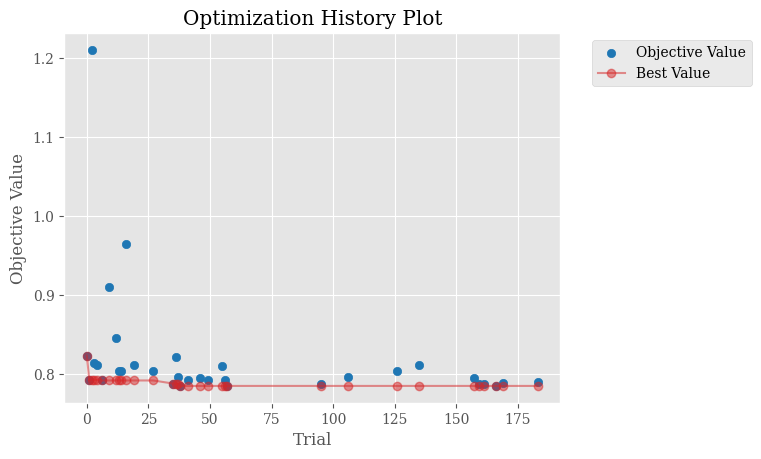

In [ ]:
folder = '/07_lw_al_lr_08_07_23'

df.to_csv(path+'/network_tuning'+folder+folder+' dataframe.csv')

## Optimization History
title = '/optimization_history'
_ = optuna.visualization.matplotlib.plot_optimization_history(study)


plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-67-3abeffdc26e9>:3: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_intermediate_values(study)
<ipython-input-67-3abeffdc26e9>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(path+'/network_tuning'+folder+title, dpi=250)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


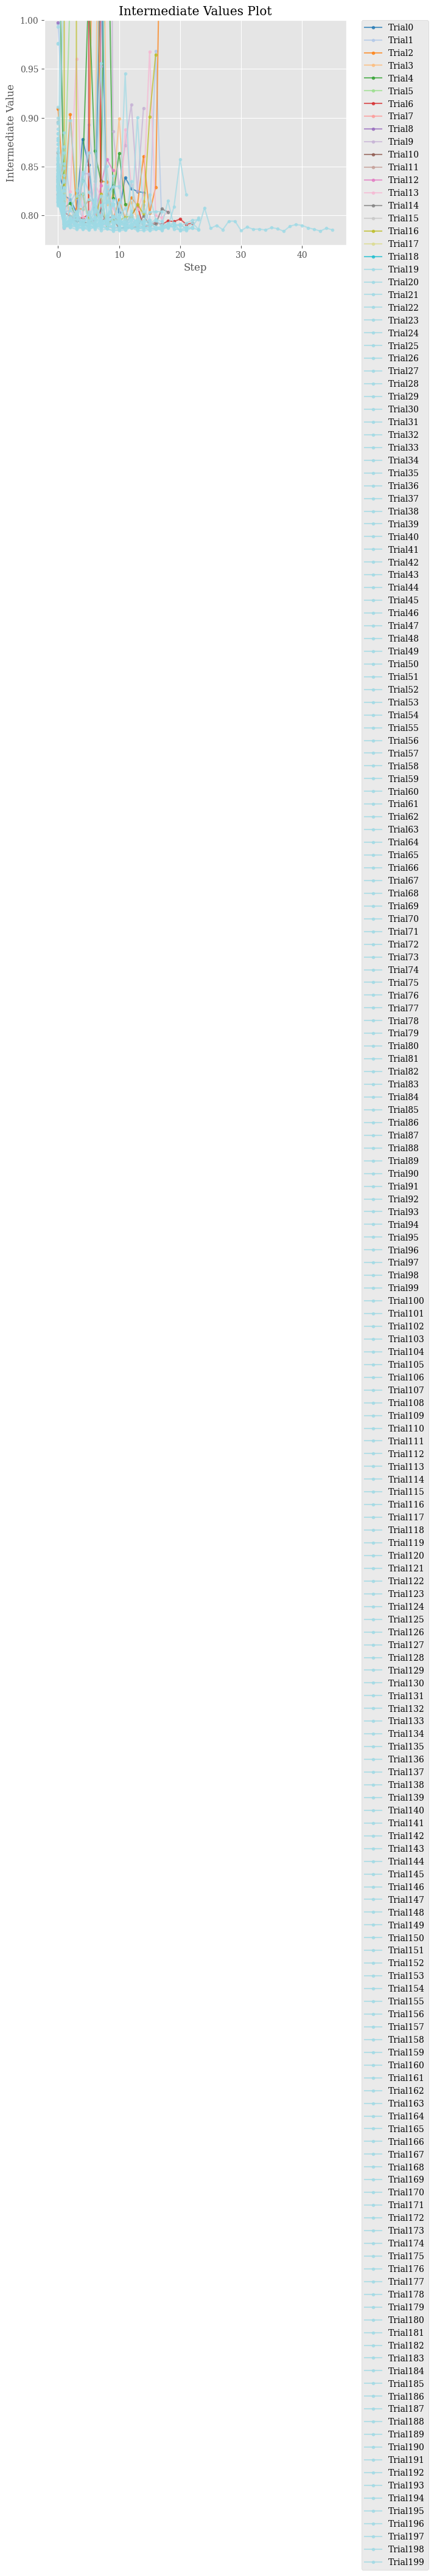

In [ ]:
## Pruning
title = '/pruning'
_ = optuna.visualization.matplotlib.plot_intermediate_values(study)
# plt.tight_layout()
plt.ylim(0.77,1)

plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-68-12478b74317b>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_contour(study)
[W 2023-07-08 19:42:18,717] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-68-12478b74317b>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


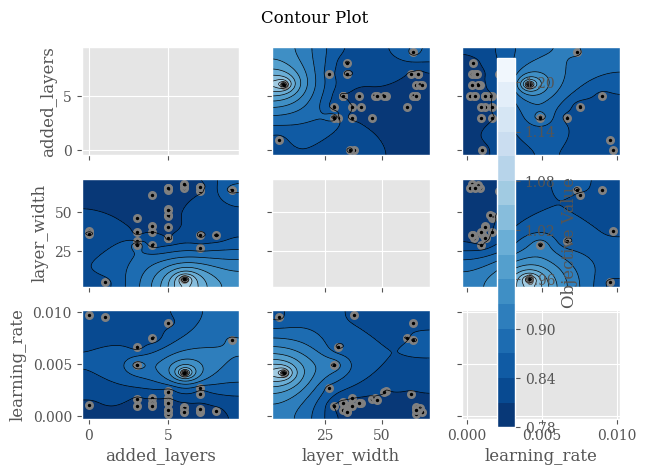

In [ ]:
## Contour
title = '/contour'
_ = optuna.visualization.matplotlib.plot_contour(study)
plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-69-17a20d2832e5>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_param_importances(study)


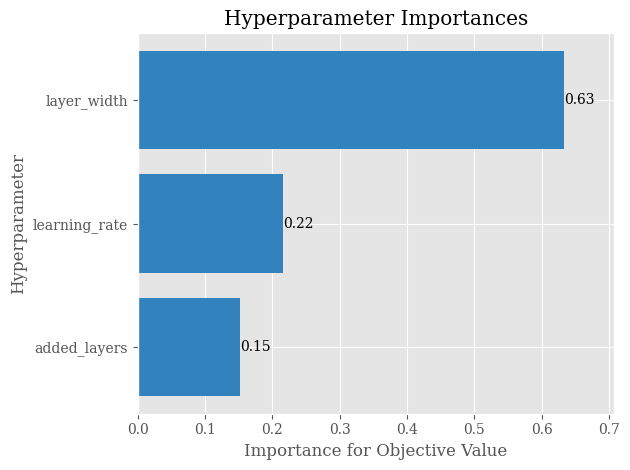

In [ ]:
## Importances
title = '/importance'
_ = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


<ipython-input-70-a697846d4ef0>:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_slice(study)


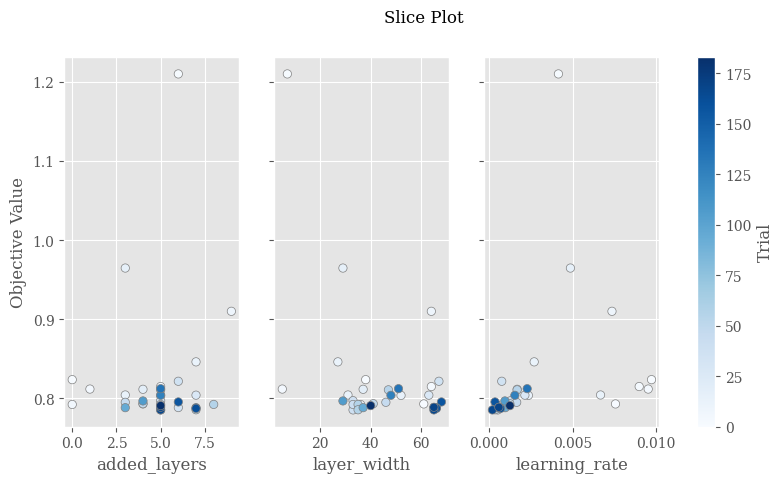

In [ ]:
## plot slice
title = '/plot_slice'
_ = optuna.visualization.matplotlib.plot_slice(study)
# plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


## Network tuning
Below I have my own set of plots for tuning hyper-parameters. These may become obsolete after using optuna.

In [ ]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:
 [0.0001]
losses:
 [0.7873]
val_losses:
 [0.7839]
early stopping:
 [48]


(0.75, 1.0)

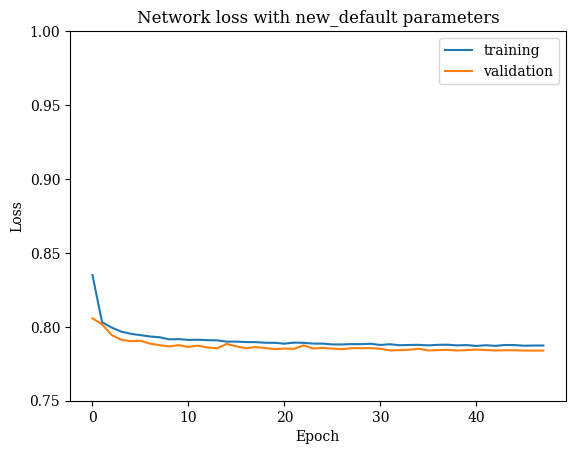

In [ ]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):
    # if i == 1:
    #     continue

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0.75,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [ ]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data. As the ratio of priors is not 1, the network predictions should be transformed to give logK.

In [ ]:
# network output f(xO).
validation_prediction = (model_instances_model[-1].predict(x_test_scaled))

# if using l-POP:
# validation_prediction = leaky_parity_odd_power(validation_prediction)
# validation_prediction = validation_prediction.numpy()

print(validation_prediction)

[[0.31254363]
 [2.7920322 ]
 [1.106809  ]
 ...
 [0.2835028 ]
 [0.56875324]
 [0.4338566 ]]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 1.000e+01, 3.000e+00,
        4.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 9.000e+00, 4.000e+00,
        1.200e+01, 1.000e+01, 8.000e+00, 8.000e+00, 1.000e+01, 1.500e+01,
        9.000e+00, 5.000e+00, 1.600e+01, 1.900e+01, 1.500e+01, 2.600e+01,
        1.100e+01, 2.700e+01, 2.900e+01, 2.000e+01, 2.800e+01, 2.900e+01,
        3.700e+01, 2.700e+01, 4.400e+01, 5.100e+01, 6.700e+01, 5.800e+01,
        7.800e+01, 7.400e+01, 1.030e+0

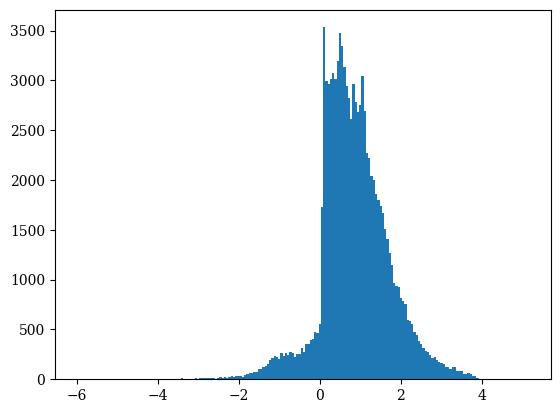

In [ ]:
# plt.hist(validation_prediction,bins=200)
# plt.plot(validation_prediction,'.')
# plt.ylim(-100,100)


# validation_prediction_mean = np.mean(validation_prediction)
# log_K_net = np.log10(np.exp(validation_prediction_mean))
# print(log_K)




# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [ ]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

(100000, 1)


In [ ]:
# perform coverage test
bin_centres, fractions, post_bin_means, post_bin_n = [],[],[],[]

for i in range(0,len(probability_array)-1):
  # bin posteriors
  indexes = np.where((posterior_model_prob > probability_array[i])
                                      & (posterior_model_prob < probability_array[i+1]))[0]
  post_bin = posterior_model_prob[indexes]
  post_bin_mean = float(np.mean(posterior_model_prob[indexes]))
  post_bin_mid = float((probability_array[i]+probability_array[i+1]) / 2)
  post_bin_size = float(len(post_bin))

  # get fraction of model 1 labels in each bin
  label_bin = y_test[indexes]
  fraction = np.sum(label_bin) / len(label_bin)

  bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_means.append(post_bin_mean), post_bin_n.append(post_bin_size)


# get the binomial error for each bin
binomial_std = np.sqrt((np.asarray(post_bin_means)*(1.-np.asarray(post_bin_means))) / np.asarray(post_bin_n))



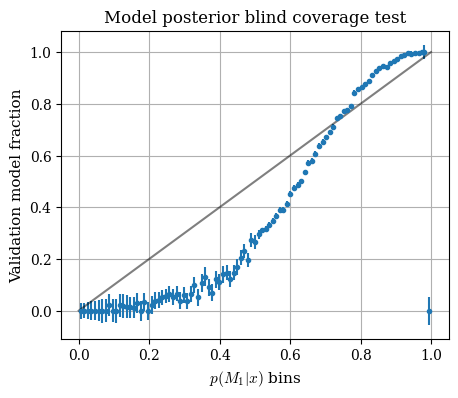

In [ ]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(post_bin_means, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

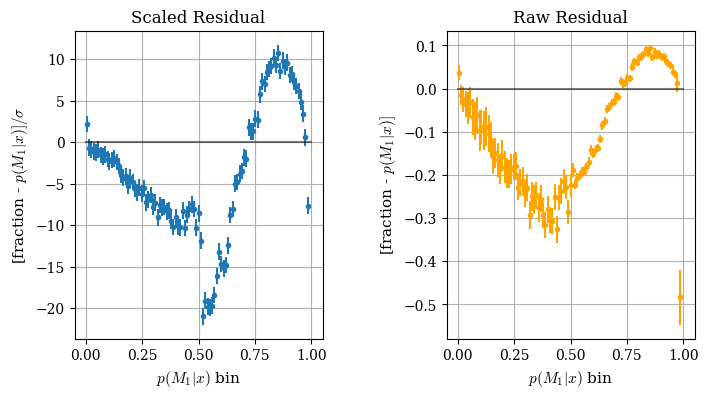

In [ ]:
residual = (np.asarray(fractions) - np.asarray(post_bin_means))/np.asarray(binomial_std)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(post_bin_means, residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(post_bin_means, residual*binomial_std,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)
